This notebook is for training the network for SVHN dataset.

In [1]:
import numpy as np
import theano
import theano.tensor as T 
import lasagne
from __future__ import print_function

import BC_layers
import BC_utils
from pylearn2.datasets.mnist import MNIST
from pylearn2.utils import serial
import timeit
import inspect
import time
import logging
from lasagne.layers import batch_norm

Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN Version is too old. Update to v5, was 3007.)


The original implementation use a script for pre-processing. I also found preprocessing script [here](https://github.com/lisa-lab/pylearn2/blob/master/pylearn2/scripts/papers/maxout/svhn_preprocessing.py), and it seems that it is from the codes for Maxout Network. So here in order to make sure I have the same preprocessing result, I use the same code in the link.

Moreover, the code for downloading and splitting the data is from [here](https://raw.githubusercontent.com/lisa-lab/pylearn2/master/pylearn2/scripts/datasets/download_svhn.sh), also in the pylearn2 library. Although we can also use the code in the previous homeworks, here I use that code for consistency of the overall training.

In [2]:
# make logging functions

logger = logging.getLogger('')
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler('experiment.log')
fh.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(message)s')
ch.setFormatter(formatter)
fh.setFormatter(formatter)
logger.addHandler(ch)
logger.addHandler(fh)

Again, here I use the same code to load the data.

In [3]:
train_set = MNIST(which_set= 'train', start=0, stop = 50000, center = True)
valid_set = MNIST(which_set= 'train', start=50000, stop = 60000, center = True)
test_set = MNIST(which_set= 'test', center = True)
    
# bc01 format
# print train_set.X.shape
train_set.X = train_set.X.reshape(-1, 1, 28, 28)
valid_set.X = valid_set.X.reshape(-1, 1, 28, 28)
test_set.X = test_set.X.reshape(-1, 1, 28, 28)
    
# flatten targets
train_set.y = np.hstack(train_set.y)
valid_set.y = np.hstack(valid_set.y)
test_set.y = np.hstack(test_set.y)

# for hinge loss 
# make targets onehot
def make_onehot(dataset, category=10):
    n_dataset = np.zeros((dataset.shape[0], category), dtype=np.int32)
    n_dataset[np.arange(n_dataset.shape[0]), dataset] = 1
    return n_dataset

train_set.y = np.subtract(np.multiply(2,make_onehot(train_set.y)),1.).astype('int32')
valid_set.y = np.subtract(np.multiply(2,make_onehot(valid_set.y)),1.).astype('int32')
test_set.y = np.subtract(np.multiply(2,make_onehot(test_set.y)),1.).astype('int32')

In [4]:
# make dataset shared variables
from theano import shared
train_set_x = shared(train_set.X, borrow=True)
train_set_y = shared(train_set.y, borrow=True)
valid_set_x = shared(valid_set.X, borrow=True)
valid_set_y = shared(valid_set.y, borrow=True)
test_set_x = shared(test_set.X, borrow=True)
test_set_y = shared(test_set.y, borrow=True)

In [5]:
def make_network(input_shape, net_arch, net_spec):
    assert len(net_arch) == len(net_spec)
    
    layer = lasagne.layers.InputLayer(shape=input_shape)
    
    layers = {'in': layer}

    for i in range(len(net_arch)):
        if net_arch[i]=='noise':
            lasagne.layers.GaussianNoiseLayer(layer,**net_spec[i])
        
        elif net_arch[i]=='dropout':
            layer = lasagne.layers.DropoutLayer(layer,**net_spec[i])
        
        elif net_arch[i]=='reshape':
            layer = lasagne.layers.ReshapeLayer(layer,**net_spec[i])
        
        elif net_arch[i]=='cnn':
            layer = BC_layers.Conv2DLayer(layer, **net_spec[i])
        
        elif net_arch[i]=='bn':
            layer = batch_norm(layer, **net_spec[i])
            
        elif net_arch[i]=='maxpool':
            layer = lasagne.layers.MaxPool2DLayer(layer, **net_spec[i])
            
        elif net_arch[i][:11]=='feedforward':
            if net_arch[i]=='feedforward_tanh':
                nonlinearity = lasagne.nonlinearities.tanh
            elif net_arch[i]=='feedforward_sigmoid':
                nonlinearity = lasagne.nonlinearities.sigmoid
            elif net_arch[i]=='feedforward_softmax':
                nonlinearity = lasagne.nonlinearities.softmax
            elif net_arch[i]=='feedforward_linear':
                nonlinearity = lasagne.nonlinearities.linear
            elif net_arch[i]=='feedforward_rectify':
                nonlinearity = lasagne.nonlinearities.rectify
            elif net_arch[i]=='feedforward_leaky':
                nonlinearity = lasagne.nonlinearities.leaky_rectify
            elif net_arch[i]=='feedforward_identity':
                nonlinearity = lasagne.nonlinearities.identity
                
            layer = BC_layers.DenseLayer(layer,nonlinearity=nonlinearity,**net_spec[i])
                
                
    layers['out'] = layer
    return layers

In [10]:
def exp_setting(binary, stochastic, dropout, batch_size=200, learning_rate=3e-4, n_epoch=1000):
    if not dropout:
        net_arch=['feedforward_rectify', 'bn', 'feedforward_rectify', 'bn', 'feedforward_rectify', 'bn', 
                  'feedforward_identity', 'bn']

        net_spec=[{'binary':binary,'stochastic':stochastic,'num_units':1024}, 
                  {'name': 'batch norm 1'}, 
                  {'binary':binary,'stochastic':stochastic,'num_units':1024}, 
                  {'name': 'batch norm 2'}, 
                  {'binary':binary,'stochastic':stochastic,'num_units':1024}, 
                  {'name': 'batch norm 3'}, 
                  {'binary':binary,'stochastic':stochastic,'num_units':10}, 
                  {'name': 'batch norm 4'}]
    else:
        # with dropout probability 0.5
        net_arch=['feedforward_rectify', 'bn', 'dropout', 'feedforward_rectify', 'bn', 'dropout', 
                  'feedforward_rectify', 'bn', 'dropout', 
                  'feedforward_identity', 'bn']

        net_spec=[{'binary':binary,'stochastic':stochastic,'num_units':1024}, 
                  {'name': 'batch norm 1'}, {'p': 0.5}, 
                  {'binary':binary,'stochastic':stochastic,'num_units':1024}, 
                  {'name': 'batch norm 2'}, {'p': 0.5}, 
                  {'binary':binary,'stochastic':stochastic,'num_units':1024}, 
                  {'name': 'batch norm 3'}, {'p': 0.5}, 
                  {'binary':binary,'stochastic':stochastic,'num_units':10}, 
                  {'name': 'batch norm 4'}]
        
    input_shape=(None, 1, 28, 28)
    Layer = make_network(input_shape,net_arch,net_spec)

    input = T.ftensor4('input')
    Y = T.imatrix('Y')
    LR = T.fscalar('learning_rate')
    
    # cost function
    # hinge loss
    cost_tr = T.mean(T.sqr(T.maximum(0.,1. - Y * lasagne.layers.get_output(Layer['out'], 
                                                                         {Layer['in']: input}, deterministic=False))))
    # compute update
    # It is said in the paper that they use sgd without momentum. However, sgd does not work!
    # Moreover, in their implementation, they also use adam.
    update = BC_utils.calculate_update(Layer, cost_tr, LR, method='adam', binary=binary)
    
    # other functions
    cost_cv = T.mean(T.sqr(T.maximum(0.,1. - Y * lasagne.layers.get_output(Layer['out'], 
                                                                         {Layer['in']: input}, deterministic=True))))
    error_model = T.mean(T.neq(T.argmax(lasagne.layers.get_output(Layer['out'], \
                                                               {Layer['in']: input}, deterministic=True), axis=1), 
                            T.argmax(Y, axis=1)), dtype='float32')
    
    n_train_batches = train_set_x.get_value(borrow=True).shape[0]
    n_valid_batches = valid_set_x.get_value(borrow=True).shape[0]
    n_test_batches = test_set_x.get_value(borrow=True).shape[0]
    n_train_batches //= batch_size
    n_valid_batches //= batch_size
    n_test_batches //= batch_size


    index = T.lscalar()

    import time
    start_time = time.time()

    logger.info('Computing function for training...')
    train_model = theano.function(
            inputs=[index, LR],
            outputs=cost_tr,
            updates=update,
            givens={
                input: train_set_x[index * batch_size: (index + 1) * batch_size],
                Y: train_set_y[index * batch_size: (index + 1) * batch_size]
            }
        )

    print('Time spent: ', time.time() - start_time)

    logger.info('Compiling cost function for testing...')
    test_model = theano.function(
            inputs=[index],
            outputs=error_model,
            givens={
                input: test_set_x[index * batch_size:(index + 1) * batch_size],
                Y: test_set_y[index * batch_size:(index + 1) * batch_size]
            }
        )
    print('Time spent: ', time.time() - start_time)

    logger.info('Compiling cost function for validation...')
    validate_model = theano.function(
            inputs=[index],
            outputs=error_model,
            givens={
                input: valid_set_x[index * batch_size:(index + 1) * batch_size],
                Y: valid_set_y[index * batch_size:(index + 1) * batch_size]
            }
        )
    print('Time spent: ', time.time() - start_time)
    
    
    # training function
    def train_nn(train_model, validate_model, test_model, LR, 
                n_train_batches, n_valid_batches, n_test_batches, n_epochs,
                verbose = True):
        """
        Function from HW3

        """

        # early-stopping parameters
        patience = 1e9  # look as this many examples regardless
        patience_increase = 15  # wait this much longer when a new best is
                               # found
        improvement_threshold = 0.99998  # a relative improvement of this much is
                                       # considered significant

        best_validation_loss = np.inf
        best_iter = 0
        test_score = 0.
        start_time = timeit.default_timer()

        epoch = 0
        best_epoch=0

        LR_decay = (3e-6/LR)**(1./n_epochs)

        tr_cost = []
        cv_error = []

        while epoch < n_epochs:
            epoch = epoch + 1
            start_epoch_time = time.time()
            
            LR = np.float32(LR)

            cur_tr_cost=0.

            for minibatch_index in range(n_train_batches):
                cost_ij = train_model(minibatch_index, LR)
                cur_tr_cost += cost_ij

            tr_cost.append(cur_tr_cost)

            validation_losses = [validate_model(i) for i
                                         in range(n_valid_batches)]
            this_validation_loss = np.mean(validation_losses)

            cv_error.append(this_validation_loss)

            if verbose:
                logger.info("Epoch {} took {} seconds, tr cost {}, validation error {}%.\n".format(
                epoch, time.time() - start_epoch_time, cur_tr_cost, this_validation_loss * 100.))

            # if we got the best validation score until now
            if this_validation_loss < best_validation_loss:
                # save best validation score and iteration number
                best_validation_loss = this_validation_loss
                best_epoch = epoch

                # test it on the test set
                test_losses = [
                            test_model(i)
                            for i in range(n_test_batches)
                    ]
                test_score = np.mean(test_losses)

                if verbose:
                    print(('     epoch %i, test error of '
                                   'best model %f %%') %
                                  (epoch, 
                                   test_score * 100.))

            # decay learning rate
            LR *= LR_decay


        end_time = timeit.default_timer()

        # Print out summary
        print('Optimization complete.')
        print('Best validation score of %f %% obtained at epoch %i, '
              'with test performance %f %%' %
              (best_validation_loss * 100., best_epoch, test_score * 100.))

        return tr_cost, cv_error
    
    learning_rate = np.float32(learning_rate)
    
    tr_cost, cv_error = train_nn(train_model, validate_model, test_model, learning_rate,
        n_train_batches, n_valid_batches, n_test_batches, n_epoch, verbose=True)
    
    return Layer, tr_cost, cv_error

In [7]:
# train the network

# no regularization
print('No regularization training...')
Layer_no_reg, tr_cost_no_reg, cv_error_no_reg = exp_setting(binary=False, stochastic=False, dropout=False)
print ('Training finished.\n')

INFO:root:Computing function for training...
Computing function for training...


No regularization training...
Time spent: 

INFO:root:Compiling cost function for testing...
Compiling cost function for testing...


 108.251429081
Time spent: 

INFO:root:Compiling cost function for validation...
Compiling cost function for validation...


 120.348217964
Time spent: 

INFO:root:Epoch 1 took 4.29098105431 seconds, tr cost 88.2170976878, validation error 2.92999986559%.

Epoch 1 took 4.29098105431 seconds, tr cost 88.2170976878, validation error 2.92999986559%.



 121.085040092
     epoch 1, test error of best model 3.550000 %

INFO:root:Epoch 2 took 4.35970807076 seconds, tr cost 27.1891091014, validation error 2.09999997169%.

Epoch 2 took 4.35970807076 seconds, tr cost 27.1891091014, validation error 2.09999997169%.




     epoch 2, test error of best model 2.510000 %

INFO:root:Epoch 3 took 4.35934209824 seconds, tr cost 8.13589851029, validation error 2.08000000566%.

Epoch 3 took 4.35934209824 seconds, tr cost 8.13589851029, validation error 2.08000000566%.




     epoch 3, test error of best model 2.160000 %

INFO:root:Epoch 4 took 4.3610022068 seconds, tr cost 2.76679056044, validation error 2.00999993831%.

Epoch 4 took 4.3610022068 seconds, tr cost 2.76679056044, validation error 2.00999993831%.




     epoch 4, test error of best model 2.150000 %

INFO:root:Epoch 5 took 4.3656680584 seconds, tr cost 1.29486473756, validation error 1.90999992192%.

Epoch 5 took 4.3656680584 seconds, tr cost 1.29486473756, validation error 1.90999992192%.




     epoch 5, test error of best model 1.910000 %

INFO:root:Epoch 6 took 4.36196708679 seconds, tr cost 0.9115805934, validation error 2.01999992132%.

Epoch 6 took 4.36196708679 seconds, tr cost 0.9115805934, validation error 2.01999992132%.

INFO:root:Epoch 7 took 4.3564260006 seconds, tr cost 0.94700255857, validation error 2.1899998188%.

Epoch 7 took 4.3564260006 seconds, tr cost 0.94700255857, validation error 2.1899998188%.

INFO:root:Epoch 8 took 4.36344695091 seconds, tr cost 0.648694831148, validation error 1.93999987096%.

Epoch 8 took 4.36344695091 seconds, tr cost 0.648694831148, validation error 1.93999987096%.

INFO:root:Epoch 9 took 4.35703682899 seconds, tr cost 0.56560563008, validation error 1.86999998987%.

Epoch 9 took 4.35703682899 seconds, tr cost 0.56560563008, validation error 1.86999998987%.




     epoch 9, test error of best model 1.970000 %

INFO:root:Epoch 10 took 4.39134907722 seconds, tr cost 0.35899493254, validation error 1.72999985516%.

Epoch 10 took 4.39134907722 seconds, tr cost 0.35899493254, validation error 1.72999985516%.




     epoch 10, test error of best model 1.880000 %

INFO:root:Epoch 11 took 4.36799883842 seconds, tr cost 0.31813123555, validation error 1.83000005782%.

Epoch 11 took 4.36799883842 seconds, tr cost 0.31813123555, validation error 1.83000005782%.

INFO:root:Epoch 12 took 4.36191391945 seconds, tr cost 0.256392643487, validation error 1.75000000745%.

Epoch 12 took 4.36191391945 seconds, tr cost 0.256392643487, validation error 1.75000000745%.

INFO:root:Epoch 13 took 4.36039113998 seconds, tr cost 0.2117424066, validation error 1.83000005782%.

Epoch 13 took 4.36039113998 seconds, tr cost 0.2117424066, validation error 1.83000005782%.

INFO:root:Epoch 14 took 4.35771489143 seconds, tr cost 0.386267189626, validation error 1.98999997228%.

Epoch 14 took 4.35771489143 seconds, tr cost 0.386267189626, validation error 1.98999997228%.

INFO:root:Epoch 15 took 4.35567712784 seconds, tr cost 0.234077336343, validation error 1.89999993891%.

Epoch 15 took 4.35567712784 seconds, tr cost 0.234077336343, validation error 1.89999993891%.

INFO:r


     epoch 16, test error of best model 1.860000 %

INFO:root:Epoch 17 took 4.36064004898 seconds, tr cost 0.324787843916, validation error 1.98999997228%.

Epoch 17 took 4.36064004898 seconds, tr cost 0.324787843916, validation error 1.98999997228%.

INFO:root:Epoch 18 took 4.36010408401 seconds, tr cost 0.36004038109, validation error 1.84000004083%.

Epoch 18 took 4.36010408401 seconds, tr cost 0.36004038109, validation error 1.84000004083%.

INFO:root:Epoch 19 took 4.35848402977 seconds, tr cost 0.185163912292, validation error 1.95999983698%.

Epoch 19 took 4.35848402977 seconds, tr cost 0.185163912292, validation error 1.95999983698%.

INFO:root:Epoch 20 took 4.3682320118 seconds, tr cost 0.222192988237, validation error 1.6799999401%.

Epoch 20 took 4.3682320118 seconds, tr cost 0.222192988237, validation error 1.6799999401%.

INFO:root:Epoch 21 took 4.35889315605 seconds, tr cost 0.117573996599, validation error 1.66999995708%.

Epoch 21 took 4.35889315605 seconds, tr cost 0.117573996599, validation error 1.66999995708%.




     epoch 21, test error of best model 1.600000 %

INFO:root:Epoch 22 took 4.35963392258 seconds, tr cost 0.0726850797119, validation error 1.59000009298%.

Epoch 22 took 4.35963392258 seconds, tr cost 0.0726850797119, validation error 1.59000009298%.




     epoch 22, test error of best model 1.590000 %

INFO:root:Epoch 23 took 4.35885691643 seconds, tr cost 0.0133125031722, validation error 1.52000011876%.

Epoch 23 took 4.35885691643 seconds, tr cost 0.0133125031722, validation error 1.52000011876%.




     epoch 23, test error of best model 1.470000 %

INFO:root:Epoch 24 took 4.35426282883 seconds, tr cost 0.111031926366, validation error 1.6799999401%.

Epoch 24 took 4.35426282883 seconds, tr cost 0.111031926366, validation error 1.6799999401%.

INFO:root:Epoch 25 took 4.35615706444 seconds, tr cost 0.176036353059, validation error 1.84000004083%.

Epoch 25 took 4.35615706444 seconds, tr cost 0.176036353059, validation error 1.84000004083%.

INFO:root:Epoch 26 took 4.36818313599 seconds, tr cost 0.356714441962, validation error 1.97999998927%.

Epoch 26 took 4.36818313599 seconds, tr cost 0.356714441962, validation error 1.97999998927%.

INFO:root:Epoch 27 took 4.35637283325 seconds, tr cost 0.16408855157, validation error 1.71999987215%.

Epoch 27 took 4.35637283325 seconds, tr cost 0.16408855157, validation error 1.71999987215%.

INFO:root:Epoch 28 took 4.35099697113 seconds, tr cost 0.056142379531, validation error 1.53000000864%.

Epoch 28 took 4.35099697113 seconds, tr cost 0.056142379531, validation error 1.53000000864%.

INFO


     epoch 31, test error of best model 1.700000 %

INFO:root:Epoch 32 took 4.36064100266 seconds, tr cost 0.0626980290808, validation error 1.57000012696%.

Epoch 32 took 4.36064100266 seconds, tr cost 0.0626980290808, validation error 1.57000012696%.

INFO:root:Epoch 33 took 4.36259317398 seconds, tr cost 0.160886367932, validation error 1.62000004202%.

Epoch 33 took 4.36259317398 seconds, tr cost 0.160886367932, validation error 1.62000004202%.

INFO:root:Epoch 34 took 4.36040997505 seconds, tr cost 0.0951456634302, validation error 1.62000004202%.

Epoch 34 took 4.36040997505 seconds, tr cost 0.0951456634302, validation error 1.62000004202%.

INFO:root:Epoch 35 took 4.35841083527 seconds, tr cost 0.077757013759, validation error 1.56999994069%.

Epoch 35 took 4.35841083527 seconds, tr cost 0.077757013759, validation error 1.56999994069%.

INFO:root:Epoch 36 took 4.35554599762 seconds, tr cost 0.0509501459598, validation error 1.46000003442%.

Epoch 36 took 4.35554599762 seconds, tr cost 0.0509501459598, validation error 1.460000034


     epoch 36, test error of best model 1.520000 %

INFO:root:Epoch 37 took 4.36361694336 seconds, tr cost 0.0453935662057, validation error 1.53000010177%.

Epoch 37 took 4.36361694336 seconds, tr cost 0.0453935662057, validation error 1.53000010177%.

INFO:root:Epoch 38 took 4.36048293114 seconds, tr cost 0.0587002916155, validation error 1.53000000864%.

Epoch 38 took 4.36048293114 seconds, tr cost 0.0587002916155, validation error 1.53000000864%.

INFO:root:Epoch 39 took 4.3671579361 seconds, tr cost 0.0294479885533, validation error 1.600000076%.

Epoch 39 took 4.3671579361 seconds, tr cost 0.0294479885533, validation error 1.600000076%.

INFO:root:Epoch 40 took 4.36197710037 seconds, tr cost 0.0592203443866, validation error 1.94000005722%.

Epoch 40 took 4.36197710037 seconds, tr cost 0.0592203443866, validation error 1.94000005722%.

INFO:root:Epoch 41 took 4.3652279377 seconds, tr cost 0.0605574037218, validation error 1.54000008479%.

Epoch 41 took 4.3652279377 seconds, tr cost 0.0605574037218, validation error 1.54000008479%.


     epoch 46, test error of best model 1.540000 %

INFO:root:Epoch 47 took 4.37151217461 seconds, tr cost 0.0044246663009, validation error 1.46000003442%.

Epoch 47 took 4.37151217461 seconds, tr cost 0.0044246663009, validation error 1.46000003442%.

INFO:root:Epoch 48 took 4.3742480278 seconds, tr cost 0.000531445173951, validation error 1.44999995828%.

Epoch 48 took 4.3742480278 seconds, tr cost 0.000531445173951, validation error 1.44999995828%.

INFO:root:Epoch 49 took 4.38250017166 seconds, tr cost 2.81318833235e-05, validation error 1.45999994129%.

Epoch 49 took 4.38250017166 seconds, tr cost 2.81318833235e-05, validation error 1.45999994129%.

INFO:root:Epoch 50 took 4.38110113144 seconds, tr cost 3.67257998732e-07, validation error 1.45999994129%.

Epoch 50 took 4.38110113144 seconds, tr cost 3.67257998732e-07, validation error 1.45999994129%.

INFO:root:Epoch 51 took 4.38511419296 seconds, tr cost 2.28733584962e-09, validation error 1.45999994129%.

Epoch 51 took 4.38511419296 seconds, tr cost 2.28733584962e-09, validation


Optimization complete.
Best validation score of 1.450000 % obtained at epoch 46, with test performance 1.540000 %
Training finished.



In [8]:
# deterministic binarization
print('Deterministic binarization training...')
Layer_det_bi, tr_cost_det_bi, cv_error_det_bi = exp_setting(binary=True, stochastic=False, dropout=False)
print ('Training finished.\n')

INFO:root:Computing function for training...
Computing function for training...


Deterministic binarization training...
Time spent: 

INFO:root:Compiling cost function for testing...
Compiling cost function for testing...


 32.1310799122
Time spent: 

INFO:root:Compiling cost function for validation...
Compiling cost function for validation...


 32.8342549801
Time spent: 

INFO:root:Epoch 1 took 4.1049349308 seconds, tr cost 159.187246125, validation error 7.47000053525%.

Epoch 1 took 4.1049349308 seconds, tr cost 159.187246125, validation error 7.47000053525%.



 33.7751629353
     epoch 1, test error of best model 8.010000 %

INFO:root:Epoch 2 took 4.08195996284 seconds, tr cost 62.7759298858, validation error 5.44000007212%.

Epoch 2 took 4.08195996284 seconds, tr cost 62.7759298858, validation error 5.44000007212%.




     epoch 2, test error of best model 6.299999 %

INFO:root:Epoch 3 took 4.07587003708 seconds, tr cost 32.8468875293, validation error 4.57000024617%.

Epoch 3 took 4.07587003708 seconds, tr cost 32.8468875293, validation error 4.57000024617%.




     epoch 3, test error of best model 5.310000 %

INFO:root:Epoch 4 took 4.0730650425 seconds, tr cost 19.6146753173, validation error 4.02999967337%.

Epoch 4 took 4.0730650425 seconds, tr cost 19.6146753173, validation error 4.02999967337%.




     epoch 4, test error of best model 4.680000 %

INFO:root:Epoch 5 took 4.08524513245 seconds, tr cost 13.3917508628, validation error 3.49999964237%.

Epoch 5 took 4.08524513245 seconds, tr cost 13.3917508628, validation error 3.49999964237%.




     epoch 5, test error of best model 4.169999 %

INFO:root:Epoch 6 took 4.35960817337 seconds, tr cost 10.0991562073, validation error 3.24000008404%.

Epoch 6 took 4.35960817337 seconds, tr cost 10.0991562073, validation error 3.24000008404%.




     epoch 6, test error of best model 3.800000 %

INFO:root:Epoch 7 took 4.13679099083 seconds, tr cost 8.13964275987, validation error 2.95999981463%.

Epoch 7 took 4.13679099083 seconds, tr cost 8.13964275987, validation error 2.95999981463%.




     epoch 7, test error of best model 3.450000 %

INFO:root:Epoch 8 took 4.28221106529 seconds, tr cost 6.74114963125, validation error 2.73999981582%.

Epoch 8 took 4.28221106529 seconds, tr cost 6.74114963125, validation error 2.73999981582%.




     epoch 8, test error of best model 3.280000 %

INFO:root:Epoch 9 took 4.22892189026 seconds, tr cost 5.69507739243, validation error 2.60999985039%.

Epoch 9 took 4.22892189026 seconds, tr cost 5.69507739243, validation error 2.60999985039%.




     epoch 9, test error of best model 3.000000 %

INFO:root:Epoch 10 took 4.07703399658 seconds, tr cost 4.83769964206, validation error 2.40999981761%.

Epoch 10 took 4.07703399658 seconds, tr cost 4.83769964206, validation error 2.40999981761%.




     epoch 10, test error of best model 2.890000 %

INFO:root:Epoch 11 took 4.32635307312 seconds, tr cost 4.15275018365, validation error 2.30000000447%.

Epoch 11 took 4.32635307312 seconds, tr cost 4.15275018365, validation error 2.30000000447%.




     epoch 11, test error of best model 2.780000 %

INFO:root:Epoch 12 took 4.63359713554 seconds, tr cost 3.57179739969, validation error 2.23999992013%.

Epoch 12 took 4.63359713554 seconds, tr cost 3.57179739969, validation error 2.23999992013%.




     epoch 12, test error of best model 2.540000 %

INFO:root:Epoch 13 took 4.36896085739 seconds, tr cost 3.06510015068, validation error 2.22999975085%.

Epoch 13 took 4.36896085739 seconds, tr cost 3.06510015068, validation error 2.22999975085%.




     epoch 13, test error of best model 2.590000 %

INFO:root:Epoch 14 took 4.07503604889 seconds, tr cost 2.6269956386, validation error 2.2199999541%.

Epoch 14 took 4.07503604889 seconds, tr cost 2.6269956386, validation error 2.2199999541%.




     epoch 14, test error of best model 2.440000 %

INFO:root:Epoch 15 took 4.33842802048 seconds, tr cost 2.25756891313, validation error 2.08000000566%.

Epoch 15 took 4.33842802048 seconds, tr cost 2.25756891313, validation error 2.08000000566%.




     epoch 15, test error of best model 2.350000 %

INFO:root:Epoch 16 took 4.39872097969 seconds, tr cost 1.92727208189, validation error 2.07000002265%.

Epoch 16 took 4.39872097969 seconds, tr cost 1.92727208189, validation error 2.07000002265%.




     epoch 16, test error of best model 2.360000 %

INFO:root:Epoch 17 took 4.53031110764 seconds, tr cost 1.6353054525, validation error 2.15999986976%.

Epoch 17 took 4.53031110764 seconds, tr cost 1.6353054525, validation error 2.15999986976%.

INFO:root:Epoch 18 took 4.46075415611 seconds, tr cost 1.40320533065, validation error 2.08999998868%.

Epoch 18 took 4.46075415611 seconds, tr cost 1.40320533065, validation error 2.08999998868%.

INFO:root:Epoch 19 took 4.62476706505 seconds, tr cost 1.17646197565, validation error 2.07000002265%.

Epoch 19 took 4.62476706505 seconds, tr cost 1.17646197565, validation error 2.07000002265%.

INFO:root:Epoch 20 took 4.4291741848 seconds, tr cost 1.0086999917, validation error 2.08999998868%.

Epoch 20 took 4.4291741848 seconds, tr cost 1.0086999917, validation error 2.08999998868%.

INFO:root:Epoch 21 took 4.48859906197 seconds, tr cost 0.872945074197, validation error 2.08000000566%.

Epoch 21 took 4.48859906197 seconds, tr cost 0.872945074197, validation error 2.08000000566%.

INFO:root:Epoc


     epoch 24, test error of best model 2.310000 %

INFO:root:Epoch 25 took 4.07071995735 seconds, tr cost 0.460733997332, validation error 2.00999993831%.

Epoch 25 took 4.07071995735 seconds, tr cost 0.460733997332, validation error 2.00999993831%.

INFO:root:Epoch 26 took 4.07472991943 seconds, tr cost 0.401303485667, validation error 1.90999992192%.

Epoch 26 took 4.07472991943 seconds, tr cost 0.401303485667, validation error 1.90999992192%.




     epoch 26, test error of best model 2.230000 %

INFO:root:Epoch 27 took 4.07682394981 seconds, tr cost 0.33288266394, validation error 1.95999983698%.

Epoch 27 took 4.07682394981 seconds, tr cost 0.33288266394, validation error 1.95999983698%.

INFO:root:Epoch 28 took 4.08174610138 seconds, tr cost 0.297440321131, validation error 1.89999993891%.

Epoch 28 took 4.08174610138 seconds, tr cost 0.297440321131, validation error 1.89999993891%.




     epoch 28, test error of best model 2.140000 %

INFO:root:Epoch 29 took 4.12607216835 seconds, tr cost 0.264729512208, validation error 1.90999992192%.

Epoch 29 took 4.12607216835 seconds, tr cost 0.264729512208, validation error 1.90999992192%.

INFO:root:Epoch 30 took 4.07449793816 seconds, tr cost 0.238281643987, validation error 1.98999997228%.

Epoch 30 took 4.07449793816 seconds, tr cost 0.238281643987, validation error 1.98999997228%.

INFO:root:Epoch 31 took 4.06448292732 seconds, tr cost 0.201936583425, validation error 1.98999997228%.

Epoch 31 took 4.06448292732 seconds, tr cost 0.201936583425, validation error 1.98999997228%.

INFO:root:Epoch 32 took 4.06498813629 seconds, tr cost 0.182452088285, validation error 1.91999990493%.

Epoch 32 took 4.06498813629 seconds, tr cost 0.182452088285, validation error 1.91999990493%.

INFO:root:Epoch 33 took 4.07122206688 seconds, tr cost 0.153687132987, validation error 1.91999990493%.

Epoch 33 took 4.07122206688 seconds, tr cost 0.153687132987, validation error 1.91999990493%.




     epoch 34, test error of best model 2.160000 %

INFO:root:Epoch 35 took 4.06920909882 seconds, tr cost 0.129640185189, validation error 1.90999992192%.

Epoch 35 took 4.06920909882 seconds, tr cost 0.129640185189, validation error 1.90999992192%.

INFO:root:Epoch 36 took 4.07102799416 seconds, tr cost 0.118328132556, validation error 1.96999981999%.

Epoch 36 took 4.07102799416 seconds, tr cost 0.118328132556, validation error 1.96999981999%.

INFO:root:Epoch 37 took 4.0676009655 seconds, tr cost 0.11790562974, validation error 1.7599998042%.

Epoch 37 took 4.0676009655 seconds, tr cost 0.11790562974, validation error 1.7599998042%.




     epoch 37, test error of best model 2.040000 %

INFO:root:Epoch 38 took 4.0799407959 seconds, tr cost 0.0970489614855, validation error 1.91000010818%.

Epoch 38 took 4.0799407959 seconds, tr cost 0.0970489614855, validation error 1.91000010818%.

INFO:root:Epoch 39 took 4.06644487381 seconds, tr cost 0.0914490673124, validation error 1.83000005782%.

Epoch 39 took 4.06644487381 seconds, tr cost 0.0914490673124, validation error 1.83000005782%.

INFO:root:Epoch 40 took 4.05969190598 seconds, tr cost 0.0722365079328, validation error 1.86000000685%.

Epoch 40 took 4.05969190598 seconds, tr cost 0.0722365079328, validation error 1.86000000685%.

INFO:root:Epoch 41 took 4.07027602196 seconds, tr cost 0.066932521432, validation error 1.83000005782%.

Epoch 41 took 4.07027602196 seconds, tr cost 0.066932521432, validation error 1.83000005782%.

INFO:root:Epoch 42 took 4.06739807129 seconds, tr cost 0.0630447498671, validation error 1.90999992192%.

Epoch 42 took 4.06739807129 seconds, tr cost 0.0630447498671, validation error 1.909999921


     epoch 46, test error of best model 2.020000 %

INFO:root:Epoch 47 took 4.07977890968 seconds, tr cost 0.0378600255423, validation error 1.94000005722%.

Epoch 47 took 4.07977890968 seconds, tr cost 0.0378600255423, validation error 1.94000005722%.

INFO:root:Epoch 48 took 4.10777688026 seconds, tr cost 0.0407136329059, validation error 1.96999981999%.

Epoch 48 took 4.10777688026 seconds, tr cost 0.0407136329059, validation error 1.96999981999%.

INFO:root:Epoch 49 took 4.08552408218 seconds, tr cost 0.0405932184096, validation error 1.88999995589%.

Epoch 49 took 4.08552408218 seconds, tr cost 0.0405932184096, validation error 1.88999995589%.

INFO:root:Epoch 50 took 4.08667302132 seconds, tr cost 0.037698296522, validation error 1.90999992192%.

Epoch 50 took 4.08667302132 seconds, tr cost 0.037698296522, validation error 1.90999992192%.

INFO:root:Epoch 51 took 4.08907103539 seconds, tr cost 0.0349596792953, validation error 1.94999985397%.

Epoch 51 took 4.08907103539 seconds, tr cost 0.0349596792953, validation error 1.9499998


Optimization complete.
Best validation score of 1.690000 % obtained at epoch 46, with test performance 2.020000 %
Training finished.



In [11]:
# stochastic binarization
print('Stochastic binarization training...')
Layer_sto_bi, tr_cost_sto_bi, cv_error_sto_bi = exp_setting(binary=True, stochastic=True, dropout=False)
print ('Training finished.\n')

INFO:root:Computing function for training...
Computing function for training...


Stochastic binarization training...
Time spent: 

INFO:root:Compiling cost function for testing...
Compiling cost function for testing...


 18.5784471035
Time spent: 

INFO:root:Compiling cost function for validation...
Compiling cost function for validation...


 19.0926990509
Time spent: 

INFO:root:Epoch 1 took 4.45988178253 seconds, tr cost 429.33414773, validation error 67.6900029182%.

Epoch 1 took 4.45988178253 seconds, tr cost 429.33414773, validation error 67.6900029182%.



 19.8488380909
     epoch 1, test error of best model 66.770005 %

INFO:root:Epoch 2 took 4.36136579514 seconds, tr cost 341.858999972, validation error 64.2999947071%.

Epoch 2 took 4.36136579514 seconds, tr cost 341.858999972, validation error 64.2999947071%.




     epoch 2, test error of best model 63.330001 %

INFO:root:Epoch 3 took 4.37751197815 seconds, tr cost 271.528522409, validation error 50.4800021648%.

Epoch 3 took 4.37751197815 seconds, tr cost 271.528522409, validation error 50.4800021648%.




     epoch 3, test error of best model 50.540000 %

INFO:root:Epoch 4 took 4.36451005936 seconds, tr cost 218.108461471, validation error 36.2099945545%.

Epoch 4 took 4.36451005936 seconds, tr cost 218.108461471, validation error 36.2099945545%.




     epoch 4, test error of best model 37.300000 %

INFO:root:Epoch 5 took 4.36089396477 seconds, tr cost 177.243494537, validation error 27.9399991035%.

Epoch 5 took 4.36089396477 seconds, tr cost 177.243494537, validation error 27.9399991035%.




     epoch 5, test error of best model 28.960001 %

INFO:root:Epoch 6 took 4.35907578468 seconds, tr cost 146.470801403, validation error 25.3299981356%.

Epoch 6 took 4.35907578468 seconds, tr cost 146.470801403, validation error 25.3299981356%.




     epoch 6, test error of best model 26.760003 %

INFO:root:Epoch 7 took 4.35619282722 seconds, tr cost 122.276059217, validation error 23.1299996376%.

Epoch 7 took 4.35619282722 seconds, tr cost 122.276059217, validation error 23.1299996376%.




     epoch 7, test error of best model 24.250001 %

INFO:root:Epoch 8 took 4.3748588562 seconds, tr cost 103.402650788, validation error 21.8799993396%.

Epoch 8 took 4.3748588562 seconds, tr cost 103.402650788, validation error 21.8799993396%.




     epoch 8, test error of best model 22.939998 %

INFO:root:Epoch 9 took 4.36786603928 seconds, tr cost 87.9091718154, validation error 19.5600017905%.

Epoch 9 took 4.36786603928 seconds, tr cost 87.9091718154, validation error 19.5600017905%.




     epoch 9, test error of best model 20.529999 %

INFO:root:Epoch 10 took 4.39849495888 seconds, tr cost 75.8168488449, validation error 18.4000000358%.

Epoch 10 took 4.39849495888 seconds, tr cost 75.8168488449, validation error 18.4000000358%.




     epoch 10, test error of best model 19.740002 %

INFO:root:Epoch 11 took 4.42892408371 seconds, tr cost 66.4451356567, validation error 17.5699979067%.

Epoch 11 took 4.42892408371 seconds, tr cost 66.4451356567, validation error 17.5699979067%.




     epoch 11, test error of best model 18.860000 %

INFO:root:Epoch 12 took 4.3719329834 seconds, tr cost 58.8330705735, validation error 16.2800014019%.

Epoch 12 took 4.3719329834 seconds, tr cost 58.8330705735, validation error 16.2800014019%.




     epoch 12, test error of best model 17.210001 %

INFO:root:Epoch 13 took 4.36548805237 seconds, tr cost 53.044426893, validation error 15.870000422%.

Epoch 13 took 4.36548805237 seconds, tr cost 53.044426893, validation error 15.870000422%.




     epoch 13, test error of best model 16.920000 %

INFO:root:Epoch 14 took 4.36245703697 seconds, tr cost 48.5556794621, validation error 14.4699990749%.

Epoch 14 took 4.36245703697 seconds, tr cost 48.5556794621, validation error 14.4699990749%.




     epoch 14, test error of best model 15.350001 %

INFO:root:Epoch 15 took 4.35384917259 seconds, tr cost 44.8674946626, validation error 13.7099996209%.

Epoch 15 took 4.35384917259 seconds, tr cost 44.8674946626, validation error 13.7099996209%.




     epoch 15, test error of best model 14.820001 %

INFO:root:Epoch 16 took 4.37369704247 seconds, tr cost 41.6856665753, validation error 13.5099992156%.

Epoch 16 took 4.37369704247 seconds, tr cost 41.6856665753, validation error 13.5099992156%.




     epoch 16, test error of best model 14.440000 %

INFO:root:Epoch 17 took 4.36806106567 seconds, tr cost 38.9985389598, validation error 12.8900006413%.

Epoch 17 took 4.36806106567 seconds, tr cost 38.9985389598, validation error 12.8900006413%.




     epoch 17, test error of best model 13.410001 %

INFO:root:Epoch 18 took 4.36749577522 seconds, tr cost 36.3214030707, validation error 12.6699998975%.

Epoch 18 took 4.36749577522 seconds, tr cost 36.3214030707, validation error 12.6699998975%.




     epoch 18, test error of best model 13.129999 %

INFO:root:Epoch 19 took 4.36297702789 seconds, tr cost 34.2607084296, validation error 11.9199998677%.

Epoch 19 took 4.36297702789 seconds, tr cost 34.2607084296, validation error 11.9199998677%.




     epoch 19, test error of best model 12.500000 %

INFO:root:Epoch 20 took 4.36703109741 seconds, tr cost 32.1187547161, validation error 11.1800000072%.

Epoch 20 took 4.36703109741 seconds, tr cost 32.1187547161, validation error 11.1800000072%.




     epoch 20, test error of best model 11.659999 %

INFO:root:Epoch 21 took 4.3559691906 seconds, tr cost 30.0619501723, validation error 11.2300008535%.

Epoch 21 took 4.3559691906 seconds, tr cost 30.0619501723, validation error 11.2300008535%.

INFO:root:Epoch 22 took 4.35589122772 seconds, tr cost 28.4133486379, validation error 10.8000002801%.

Epoch 22 took 4.35589122772 seconds, tr cost 28.4133486379, validation error 10.8000002801%.




     epoch 22, test error of best model 11.220000 %

INFO:root:Epoch 23 took 4.36038684845 seconds, tr cost 26.9293583341, validation error 10.5299986899%.

Epoch 23 took 4.36038684845 seconds, tr cost 26.9293583341, validation error 10.5299986899%.




     epoch 23, test error of best model 10.620001 %

INFO:root:Epoch 24 took 4.36463093758 seconds, tr cost 25.3654180824, validation error 9.6400000155%.

Epoch 24 took 4.36463093758 seconds, tr cost 25.3654180824, validation error 9.6400000155%.




     epoch 24, test error of best model 9.810001 %

INFO:root:Epoch 25 took 4.36548018456 seconds, tr cost 24.2059833328, validation error 9.58999916911%.

Epoch 25 took 4.36548018456 seconds, tr cost 24.2059833328, validation error 9.58999916911%.




     epoch 25, test error of best model 9.790000 %

INFO:root:Epoch 26 took 4.3581199646 seconds, tr cost 23.0678091903, validation error 9.31000038981%.

Epoch 26 took 4.3581199646 seconds, tr cost 23.0678091903, validation error 9.31000038981%.




     epoch 26, test error of best model 9.459999 %

INFO:root:Epoch 27 took 4.35130095482 seconds, tr cost 21.946838589, validation error 8.84000137448%.

Epoch 27 took 4.35130095482 seconds, tr cost 21.946838589, validation error 8.84000137448%.




     epoch 27, test error of best model 9.039999 %

INFO:root:Epoch 28 took 4.35427498817 seconds, tr cost 21.0673006234, validation error 9.01000052691%.

Epoch 28 took 4.35427498817 seconds, tr cost 21.0673006234, validation error 9.01000052691%.

INFO:root:Epoch 29 took 4.3554558754 seconds, tr cost 20.2953726171, validation error 8.50999951363%.

Epoch 29 took 4.3554558754 seconds, tr cost 20.2953726171, validation error 8.50999951363%.




     epoch 29, test error of best model 8.600000 %

INFO:root:Epoch 30 took 4.38489890099 seconds, tr cost 19.4415413906, validation error 8.56999978423%.

Epoch 30 took 4.38489890099 seconds, tr cost 19.4415413906, validation error 8.56999978423%.

INFO:root:Epoch 31 took 4.36446905136 seconds, tr cost 18.7019447222, validation error 8.03999975324%.

Epoch 31 took 4.36446905136 seconds, tr cost 18.7019447222, validation error 8.03999975324%.




     epoch 31, test error of best model 8.310001 %

INFO:root:Epoch 32 took 4.35263800621 seconds, tr cost 18.2433264394, validation error 8.01999941468%.

Epoch 32 took 4.35263800621 seconds, tr cost 18.2433264394, validation error 8.01999941468%.




     epoch 32, test error of best model 8.189999 %

INFO:root:Epoch 33 took 4.3544459343 seconds, tr cost 17.6133397612, validation error 7.83999934793%.

Epoch 33 took 4.3544459343 seconds, tr cost 17.6133397612, validation error 7.83999934793%.




     epoch 33, test error of best model 7.990000 %

INFO:root:Epoch 34 took 4.34973502159 seconds, tr cost 16.9908476312, validation error 7.69999995828%.

Epoch 34 took 4.34973502159 seconds, tr cost 16.9908476312, validation error 7.69999995828%.




     epoch 34, test error of best model 7.820000 %

INFO:root:Epoch 35 took 4.35545301437 seconds, tr cost 16.574064568, validation error 7.44999945164%.

Epoch 35 took 4.35545301437 seconds, tr cost 16.574064568, validation error 7.44999945164%.




     epoch 35, test error of best model 7.680000 %

INFO:root:Epoch 36 took 4.35854482651 seconds, tr cost 16.0651591467, validation error 7.19000026584%.

Epoch 36 took 4.35854482651 seconds, tr cost 16.0651591467, validation error 7.19000026584%.




     epoch 36, test error of best model 7.439999 %

INFO:root:Epoch 37 took 4.35439395905 seconds, tr cost 15.7136927489, validation error 7.00000077486%.

Epoch 37 took 4.35439395905 seconds, tr cost 15.7136927489, validation error 7.00000077486%.




     epoch 37, test error of best model 7.260000 %

INFO:root:Epoch 38 took 4.36602711678 seconds, tr cost 15.2881406186, validation error 6.74000009894%.

Epoch 38 took 4.36602711678 seconds, tr cost 15.2881406186, validation error 6.74000009894%.




     epoch 38, test error of best model 6.890000 %

INFO:root:Epoch 39 took 4.36457395554 seconds, tr cost 14.8144576648, validation error 6.80000036955%.

Epoch 39 took 4.36457395554 seconds, tr cost 14.8144576648, validation error 6.80000036955%.

INFO:root:Epoch 40 took 4.36123800278 seconds, tr cost 14.4092871808, validation error 6.56000003219%.

Epoch 40 took 4.36123800278 seconds, tr cost 14.4092871808, validation error 6.56000003219%.




     epoch 40, test error of best model 6.750000 %

INFO:root:Epoch 41 took 4.35353302956 seconds, tr cost 14.144207168, validation error 6.2199998647%.

Epoch 41 took 4.35353302956 seconds, tr cost 14.144207168, validation error 6.2199998647%.




     epoch 41, test error of best model 6.630000 %

INFO:root:Epoch 42 took 4.35464692116 seconds, tr cost 13.7838769547, validation error 6.15999996662%.

Epoch 42 took 4.35464692116 seconds, tr cost 13.7838769547, validation error 6.15999996662%.




     epoch 42, test error of best model 6.500000 %

INFO:root:Epoch 43 took 4.36693382263 seconds, tr cost 13.5352614665, validation error 6.15000016987%.

Epoch 43 took 4.36693382263 seconds, tr cost 13.5352614665, validation error 6.15000016987%.




     epoch 43, test error of best model 6.519999 %

INFO:root:Epoch 44 took 4.35457110405 seconds, tr cost 13.2130134868, validation error 6.02000057697%.

Epoch 44 took 4.35457110405 seconds, tr cost 13.2130134868, validation error 6.02000057697%.




     epoch 44, test error of best model 6.530000 %

INFO:root:Epoch 45 took 4.35924196243 seconds, tr cost 12.9673522241, validation error 5.84000013769%.

Epoch 45 took 4.35924196243 seconds, tr cost 12.9673522241, validation error 5.84000013769%.




     epoch 45, test error of best model 6.440000 %

INFO:root:Epoch 46 took 4.35315895081 seconds, tr cost 12.7470167801, validation error 5.51000013947%.

Epoch 46 took 4.35315895081 seconds, tr cost 12.7470167801, validation error 5.51000013947%.




     epoch 46, test error of best model 6.090000 %

INFO:root:Epoch 47 took 4.35318303108 seconds, tr cost 12.4380330959, validation error 5.55000007153%.

Epoch 47 took 4.35318303108 seconds, tr cost 12.4380330959, validation error 5.55000007153%.

INFO:root:Epoch 48 took 4.35382294655 seconds, tr cost 12.2268500514, validation error 5.26000037789%.

Epoch 48 took 4.35382294655 seconds, tr cost 12.2268500514, validation error 5.26000037789%.




     epoch 48, test error of best model 5.880000 %

INFO:root:Epoch 49 took 4.40208697319 seconds, tr cost 12.0095046869, validation error 5.38000054657%.

Epoch 49 took 4.40208697319 seconds, tr cost 12.0095046869, validation error 5.38000054657%.

INFO:root:Epoch 50 took 4.38313698769 seconds, tr cost 11.7430934578, validation error 5.18999993801%.

Epoch 50 took 4.38313698769 seconds, tr cost 11.7430934578, validation error 5.18999993801%.




     epoch 50, test error of best model 5.830000 %

INFO:root:Epoch 51 took 4.35758900642 seconds, tr cost 11.5673256879, validation error 5.16999959946%.

Epoch 51 took 4.35758900642 seconds, tr cost 11.5673256879, validation error 5.16999959946%.




     epoch 51, test error of best model 5.699999 %

INFO:root:Epoch 52 took 4.35580801964 seconds, tr cost 11.3637468689, validation error 5.11000007391%.

Epoch 52 took 4.35580801964 seconds, tr cost 11.3637468689, validation error 5.11000007391%.




     epoch 52, test error of best model 5.729999 %

INFO:root:Epoch 53 took 4.36597418785 seconds, tr cost 11.1087711297, validation error 5.11000007391%.

Epoch 53 took 4.36597418785 seconds, tr cost 11.1087711297, validation error 5.11000007391%.

INFO:root:Epoch 54 took 4.36353492737 seconds, tr cost 10.9584777102, validation error 4.98000010848%.

Epoch 54 took 4.36353492737 seconds, tr cost 10.9584777102, validation error 4.98000010848%.




     epoch 54, test error of best model 5.510000 %

INFO:root:Epoch 55 took 4.35725402832 seconds, tr cost 10.8048952678, validation error 4.81999963522%.

Epoch 55 took 4.35725402832 seconds, tr cost 10.8048952678, validation error 4.81999963522%.




     epoch 55, test error of best model 5.350000 %

INFO:root:Epoch 56 took 4.35441088676 seconds, tr cost 10.6319388295, validation error 4.76999990642%.

Epoch 56 took 4.35441088676 seconds, tr cost 10.6319388295, validation error 4.76999990642%.




     epoch 56, test error of best model 5.300000 %

INFO:root:Epoch 57 took 4.36857581139 seconds, tr cost 10.5514612433, validation error 4.65999990702%.

Epoch 57 took 4.36857581139 seconds, tr cost 10.5514612433, validation error 4.65999990702%.




     epoch 57, test error of best model 5.230000 %

INFO:root:Epoch 58 took 4.35113096237 seconds, tr cost 10.3377978993, validation error 4.74000014365%.

Epoch 58 took 4.35113096237 seconds, tr cost 10.3377978993, validation error 4.74000014365%.

INFO:root:Epoch 59 took 4.35159611702 seconds, tr cost 10.1025826814, validation error 4.72999997437%.

Epoch 59 took 4.35159611702 seconds, tr cost 10.1025826814, validation error 4.72999997437%.

INFO:root:Epoch 60 took 4.34470009804 seconds, tr cost 9.9740777155, validation error 4.58000004292%.

Epoch 60 took 4.34470009804 seconds, tr cost 9.9740777155, validation error 4.58000004292%.




     epoch 60, test error of best model 5.050000 %

INFO:root:Epoch 61 took 4.35187387466 seconds, tr cost 9.86066057613, validation error 4.49000038207%.

Epoch 61 took 4.35187387466 seconds, tr cost 9.86066057613, validation error 4.49000038207%.




     epoch 61, test error of best model 5.000000 %

INFO:root:Epoch 62 took 4.34614396095 seconds, tr cost 9.63406108116, validation error 4.39999997616%.

Epoch 62 took 4.34614396095 seconds, tr cost 9.63406108116, validation error 4.39999997616%.




     epoch 62, test error of best model 4.940000 %

INFO:root:Epoch 63 took 4.4134349823 seconds, tr cost 9.54973748646, validation error 4.2500000447%.

Epoch 63 took 4.4134349823 seconds, tr cost 9.54973748646, validation error 4.2500000447%.




     epoch 63, test error of best model 4.810000 %

INFO:root:Epoch 64 took 4.38025093079 seconds, tr cost 9.42628085457, validation error 4.36000004411%.

Epoch 64 took 4.38025093079 seconds, tr cost 9.42628085457, validation error 4.36000004411%.

INFO:root:Epoch 65 took 4.45543408394 seconds, tr cost 9.32165028876, validation error 4.15000021458%.

Epoch 65 took 4.45543408394 seconds, tr cost 9.32165028876, validation error 4.15000021458%.




     epoch 65, test error of best model 4.710000 %

INFO:root:Epoch 66 took 4.39276599884 seconds, tr cost 9.10046880511, validation error 4.36000004411%.

Epoch 66 took 4.39276599884 seconds, tr cost 9.10046880511, validation error 4.36000004411%.

INFO:root:Epoch 67 took 4.36319518089 seconds, tr cost 9.067142322, validation error 4.01999987662%.

Epoch 67 took 4.36319518089 seconds, tr cost 9.067142322, validation error 4.01999987662%.




     epoch 67, test error of best model 4.630000 %

INFO:root:Epoch 68 took 4.36105895042 seconds, tr cost 8.98485306822, validation error 3.98999974132%.

Epoch 68 took 4.36105895042 seconds, tr cost 8.98485306822, validation error 3.98999974132%.




     epoch 68, test error of best model 4.570000 %

INFO:root:Epoch 69 took 4.35346984863 seconds, tr cost 8.79443753667, validation error 3.96999977529%.

Epoch 69 took 4.35346984863 seconds, tr cost 8.79443753667, validation error 3.96999977529%.




     epoch 69, test error of best model 4.499999 %

INFO:root:Epoch 70 took 4.36828398705 seconds, tr cost 8.77727264781, validation error 3.83999980986%.

Epoch 70 took 4.36828398705 seconds, tr cost 8.77727264781, validation error 3.83999980986%.




     epoch 70, test error of best model 4.469999 %

INFO:root:Epoch 71 took 4.37832212448 seconds, tr cost 8.59333397164, validation error 3.75999994576%.

Epoch 71 took 4.37832212448 seconds, tr cost 8.59333397164, validation error 3.75999994576%.




     epoch 71, test error of best model 4.390000 %

INFO:root:Epoch 72 took 4.40605211258 seconds, tr cost 8.45743078728, validation error 3.70999984443%.

Epoch 72 took 4.40605211258 seconds, tr cost 8.45743078728, validation error 3.70999984443%.




     epoch 72, test error of best model 4.310000 %

INFO:root:Epoch 73 took 4.40856003761 seconds, tr cost 8.44841796645, validation error 3.81000004709%.

Epoch 73 took 4.40856003761 seconds, tr cost 8.44841796645, validation error 3.81000004709%.

INFO:root:Epoch 74 took 4.4381840229 seconds, tr cost 8.31789900163, validation error 3.66999991238%.

Epoch 74 took 4.4381840229 seconds, tr cost 8.31789900163, validation error 3.66999991238%.




     epoch 74, test error of best model 4.210000 %

INFO:root:Epoch 75 took 4.37675309181 seconds, tr cost 8.20624536473, validation error 3.77000011504%.

Epoch 75 took 4.37675309181 seconds, tr cost 8.20624536473, validation error 3.77000011504%.

INFO:root:Epoch 76 took 4.37320899963 seconds, tr cost 8.09346633515, validation error 3.64999957383%.

Epoch 76 took 4.37320899963 seconds, tr cost 8.09346633515, validation error 3.64999957383%.




     epoch 76, test error of best model 4.100000 %

INFO:root:Epoch 77 took 4.38277792931 seconds, tr cost 8.01268208521, validation error 3.68000008166%.

Epoch 77 took 4.38277792931 seconds, tr cost 8.01268208521, validation error 3.68000008166%.

INFO:root:Epoch 78 took 4.36284613609 seconds, tr cost 7.93203251115, validation error 3.6599997431%.

Epoch 78 took 4.36284613609 seconds, tr cost 7.93203251115, validation error 3.6599997431%.

INFO:root:Epoch 79 took 4.37660622597 seconds, tr cost 7.9284020042, validation error 3.72000001371%.

Epoch 79 took 4.37660622597 seconds, tr cost 7.9284020042, validation error 3.72000001371%.

INFO:root:Epoch 80 took 4.37411308289 seconds, tr cost 7.80107272587, validation error 3.62999998033%.

Epoch 80 took 4.37411308289 seconds, tr cost 7.80107272587, validation error 3.62999998033%.




     epoch 80, test error of best model 4.090000 %

INFO:root:Epoch 81 took 4.36800599098 seconds, tr cost 7.76102321143, validation error 3.49999964237%.

Epoch 81 took 4.36800599098 seconds, tr cost 7.76102321143, validation error 3.49999964237%.




     epoch 81, test error of best model 3.950000 %

INFO:root:Epoch 82 took 4.37213110924 seconds, tr cost 7.57129580621, validation error 3.58999967575%.

Epoch 82 took 4.37213110924 seconds, tr cost 7.57129580621, validation error 3.58999967575%.

INFO:root:Epoch 83 took 4.37855911255 seconds, tr cost 7.49655971738, validation error 3.5300001502%.

Epoch 83 took 4.37855911255 seconds, tr cost 7.49655971738, validation error 3.5300001502%.

INFO:root:Epoch 84 took 4.38972187042 seconds, tr cost 7.47788412687, validation error 3.44999954104%.

Epoch 84 took 4.38972187042 seconds, tr cost 7.47788412687, validation error 3.44999954104%.




     epoch 84, test error of best model 3.880000 %

INFO:root:Epoch 85 took 4.37303996086 seconds, tr cost 7.39775314707, validation error 3.5199996084%.

Epoch 85 took 4.37303996086 seconds, tr cost 7.39775314707, validation error 3.5199996084%.

INFO:root:Epoch 86 took 4.36436605453 seconds, tr cost 7.27902754299, validation error 3.40999998152%.

Epoch 86 took 4.36436605453 seconds, tr cost 7.27902754299, validation error 3.40999998152%.




     epoch 86, test error of best model 3.850000 %

INFO:root:Epoch 87 took 4.36193108559 seconds, tr cost 7.20232172485, validation error 3.45999971032%.

Epoch 87 took 4.36193108559 seconds, tr cost 7.20232172485, validation error 3.45999971032%.

INFO:root:Epoch 88 took 4.34787392616 seconds, tr cost 7.13630920689, validation error 3.52999977767%.

Epoch 88 took 4.34787392616 seconds, tr cost 7.13630920689, validation error 3.52999977767%.

INFO:root:Epoch 89 took 4.3456838131 seconds, tr cost 7.1348244522, validation error 3.33999991417%.

Epoch 89 took 4.3456838131 seconds, tr cost 7.1348244522, validation error 3.33999991417%.




     epoch 89, test error of best model 3.790000 %

INFO:root:Epoch 90 took 4.36756110191 seconds, tr cost 7.05501103454, validation error 3.40999960899%.

Epoch 90 took 4.36756110191 seconds, tr cost 7.05501103454, validation error 3.40999960899%.

INFO:root:Epoch 91 took 4.34691786766 seconds, tr cost 6.93182579793, validation error 3.37999947369%.

Epoch 91 took 4.34691786766 seconds, tr cost 6.93182579793, validation error 3.37999947369%.

INFO:root:Epoch 92 took 4.40281200409 seconds, tr cost 6.89007633249, validation error 3.35999988019%.

Epoch 92 took 4.40281200409 seconds, tr cost 6.89007633249, validation error 3.35999988019%.

INFO:root:Epoch 93 took 4.37074995041 seconds, tr cost 6.88569865961, validation error 3.28000001609%.

Epoch 93 took 4.37074995041 seconds, tr cost 6.88569865961, validation error 3.28000001609%.




     epoch 93, test error of best model 3.600000 %

INFO:root:Epoch 94 took 4.34010195732 seconds, tr cost 6.73021314109, validation error 3.31999957561%.

Epoch 94 took 4.34010195732 seconds, tr cost 6.73021314109, validation error 3.31999957561%.

INFO:root:Epoch 95 took 4.44750499725 seconds, tr cost 6.72530860763, validation error 3.26999984682%.

Epoch 95 took 4.44750499725 seconds, tr cost 6.72530860763, validation error 3.26999984682%.




     epoch 95, test error of best model 3.570000 %

INFO:root:Epoch 96 took 4.41716098785 seconds, tr cost 6.67021553147, validation error 3.24000008404%.

Epoch 96 took 4.41716098785 seconds, tr cost 6.67021553147, validation error 3.24000008404%.




     epoch 96, test error of best model 3.500000 %

INFO:root:Epoch 97 took 4.4044611454 seconds, tr cost 6.63061174419, validation error 3.20999994874%.

Epoch 97 took 4.4044611454 seconds, tr cost 6.63061174419, validation error 3.20999994874%.




     epoch 97, test error of best model 3.520000 %

INFO:root:Epoch 98 took 4.45258307457 seconds, tr cost 6.59657822684, validation error 3.18999998271%.

Epoch 98 took 4.45258307457 seconds, tr cost 6.59657822684, validation error 3.18999998271%.




     epoch 98, test error of best model 3.510000 %

INFO:root:Epoch 99 took 4.3547911644 seconds, tr cost 6.46036465594, validation error 3.30999977887%.

Epoch 99 took 4.3547911644 seconds, tr cost 6.46036465594, validation error 3.30999977887%.

INFO:root:Epoch 100 took 4.39775204659 seconds, tr cost 6.4050678508, validation error 3.09999994934%.

Epoch 100 took 4.39775204659 seconds, tr cost 6.4050678508, validation error 3.09999994934%.




     epoch 100, test error of best model 3.380000 %

INFO:root:Epoch 101 took 4.47741293907 seconds, tr cost 6.33502808786, validation error 3.12999971211%.

Epoch 101 took 4.47741293907 seconds, tr cost 6.33502808786, validation error 3.12999971211%.

INFO:root:Epoch 102 took 4.53721809387 seconds, tr cost 6.42102053512, validation error 3.11999991536%.

Epoch 102 took 4.53721809387 seconds, tr cost 6.42102053512, validation error 3.11999991536%.

INFO:root:Epoch 103 took 4.3832681179 seconds, tr cost 6.31050852681, validation error 3.0700000003%.

Epoch 103 took 4.3832681179 seconds, tr cost 6.31050852681, validation error 3.0700000003%.




     epoch 103, test error of best model 3.360000 %

INFO:root:Epoch 104 took 4.40570998192 seconds, tr cost 6.22422950659, validation error 3.02999969572%.

Epoch 104 took 4.40570998192 seconds, tr cost 6.22422950659, validation error 3.02999969572%.




     epoch 104, test error of best model 3.320000 %

INFO:root:Epoch 105 took 4.42029905319 seconds, tr cost 6.18099020136, validation error 3.07999961078%.

Epoch 105 took 4.42029905319 seconds, tr cost 6.18099020136, validation error 3.07999961078%.

INFO:root:Epoch 106 took 4.45450091362 seconds, tr cost 6.20714178706, validation error 3.05000003427%.

Epoch 106 took 4.45450091362 seconds, tr cost 6.20714178706, validation error 3.05000003427%.

INFO:root:Epoch 107 took 4.44514489174 seconds, tr cost 6.1275765018, validation error 2.99999993294%.

Epoch 107 took 4.44514489174 seconds, tr cost 6.1275765018, validation error 2.99999993294%.




     epoch 107, test error of best model 3.250000 %

INFO:root:Epoch 108 took 4.41264009476 seconds, tr cost 6.07334434332, validation error 2.99999974668%.

Epoch 108 took 4.41264009476 seconds, tr cost 6.07334434332, validation error 2.99999974668%.




     epoch 108, test error of best model 3.260000 %

INFO:root:Epoch 109 took 4.42198395729 seconds, tr cost 5.98179063544, validation error 3.00999991596%.

Epoch 109 took 4.42198395729 seconds, tr cost 5.98179063544, validation error 3.00999991596%.

INFO:root:Epoch 110 took 4.40829801559 seconds, tr cost 5.95914459956, validation error 2.99999993294%.

Epoch 110 took 4.40829801559 seconds, tr cost 5.95914459956, validation error 2.99999993294%.

INFO:root:Epoch 111 took 4.40060019493 seconds, tr cost 6.05545496621, validation error 3.01999971271%.

Epoch 111 took 4.40060019493 seconds, tr cost 6.05545496621, validation error 3.01999971271%.

INFO:root:Epoch 112 took 4.3897819519 seconds, tr cost 5.93647781441, validation error 2.94999983162%.

Epoch 112 took 4.3897819519 seconds, tr cost 5.93647781441, validation error 2.94999983162%.




     epoch 112, test error of best model 3.100000 %

INFO:root:Epoch 113 took 4.379155159 seconds, tr cost 5.9000951624, validation error 2.91999988258%.

Epoch 113 took 4.379155159 seconds, tr cost 5.9000951624, validation error 2.91999988258%.




     epoch 113, test error of best model 3.110000 %

INFO:root:Epoch 114 took 4.3891658783 seconds, tr cost 5.83190932141, validation error 2.97999996692%.

Epoch 114 took 4.3891658783 seconds, tr cost 5.83190932141, validation error 2.97999996692%.

INFO:root:Epoch 115 took 4.36609888077 seconds, tr cost 5.71007644514, validation error 2.87999995053%.

Epoch 115 took 4.36609888077 seconds, tr cost 5.71007644514, validation error 2.87999995053%.




     epoch 115, test error of best model 3.049999 %

INFO:root:Epoch 116 took 4.37197208405 seconds, tr cost 5.61862539347, validation error 2.89999991655%.

Epoch 116 took 4.37197208405 seconds, tr cost 5.61862539347, validation error 2.89999991655%.

INFO:root:Epoch 117 took 4.37399721146 seconds, tr cost 5.64161673949, validation error 2.879999578%.

Epoch 117 took 4.37399721146 seconds, tr cost 5.64161673949, validation error 2.879999578%.




     epoch 117, test error of best model 2.940000 %

INFO:root:Epoch 118 took 4.37019991875 seconds, tr cost 5.66593796333, validation error 2.8599999845%.

Epoch 118 took 4.37019991875 seconds, tr cost 5.66593796333, validation error 2.8599999845%.




     epoch 118, test error of best model 3.080000 %

INFO:root:Epoch 119 took 4.37042307854 seconds, tr cost 5.62309709472, validation error 2.95999981463%.

Epoch 119 took 4.37042307854 seconds, tr cost 5.62309709472, validation error 2.95999981463%.

INFO:root:Epoch 120 took 4.37547206879 seconds, tr cost 5.49483428319, validation error 2.76999995112%.

Epoch 120 took 4.37547206879 seconds, tr cost 5.49483428319, validation error 2.76999995112%.




     epoch 120, test error of best model 2.940000 %

INFO:root:Epoch 121 took 4.37728500366 seconds, tr cost 5.51648972963, validation error 2.8599999845%.

Epoch 121 took 4.37728500366 seconds, tr cost 5.51648972963, validation error 2.8599999845%.

INFO:root:Epoch 122 took 4.37642216682 seconds, tr cost 5.39269164386, validation error 2.95000001788%.

Epoch 122 took 4.37642216682 seconds, tr cost 5.39269164386, validation error 2.95000001788%.

INFO:root:Epoch 123 took 4.36865401268 seconds, tr cost 5.43278142093, validation error 2.8299998492%.

Epoch 123 took 4.36865401268 seconds, tr cost 5.43278142093, validation error 2.8299998492%.

INFO:root:Epoch 124 took 4.37948298454 seconds, tr cost 5.44596735544, validation error 2.89999991655%.

Epoch 124 took 4.37948298454 seconds, tr cost 5.44596735544, validation error 2.89999991655%.

INFO:root:Epoch 125 took 4.37092995644 seconds, tr cost 5.35819343265, validation error 2.8299998492%.

Epoch 125 took 4.37092995644 seconds, tr cost 5.35819343265, validation error 2.8299998492%.

INFO:r


     epoch 133, test error of best model 2.800000 %

INFO:root:Epoch 134 took 4.37666678429 seconds, tr cost 5.06788565618, validation error 2.78999991715%.

Epoch 134 took 4.37666678429 seconds, tr cost 5.06788565618, validation error 2.78999991715%.

INFO:root:Epoch 135 took 4.37340188026 seconds, tr cost 5.06920225399, validation error 2.74000000209%.

Epoch 135 took 4.37340188026 seconds, tr cost 5.06920225399, validation error 2.74000000209%.

INFO:root:Epoch 136 took 4.44754600525 seconds, tr cost 4.99226804684, validation error 2.88999956101%.

Epoch 136 took 4.44754600525 seconds, tr cost 4.99226804684, validation error 2.88999956101%.

INFO:root:Epoch 137 took 4.36819601059 seconds, tr cost 5.05645276909, validation error 2.77999974787%.

Epoch 137 took 4.36819601059 seconds, tr cost 5.05645276909, validation error 2.77999974787%.

INFO:root:Epoch 138 took 4.3607480526 seconds, tr cost 4.94568536282, validation error 2.70999986678%.

Epoch 138 took 4.3607480526 seconds, tr cost 4.94568536282, validation error 2.70999986678%.




     epoch 138, test error of best model 2.860000 %

INFO:root:Epoch 139 took 4.36868476868 seconds, tr cost 5.03828668402, validation error 2.86999996752%.

Epoch 139 took 4.36868476868 seconds, tr cost 5.03828668402, validation error 2.86999996752%.

INFO:root:Epoch 140 took 4.37393093109 seconds, tr cost 4.87642848983, validation error 2.68999990076%.

Epoch 140 took 4.37393093109 seconds, tr cost 4.87642848983, validation error 2.68999990076%.




     epoch 140, test error of best model 2.800000 %

INFO:root:Epoch 141 took 4.37360596657 seconds, tr cost 4.86928625734, validation error 2.76999976486%.

Epoch 141 took 4.37360596657 seconds, tr cost 4.86928625734, validation error 2.76999976486%.

INFO:root:Epoch 142 took 4.36053395271 seconds, tr cost 4.85245855544, validation error 2.63999979943%.

Epoch 142 took 4.36053395271 seconds, tr cost 4.85245855544, validation error 2.63999979943%.




     epoch 142, test error of best model 2.730000 %

INFO:root:Epoch 143 took 4.36164903641 seconds, tr cost 4.82889115912, validation error 2.68999990076%.

Epoch 143 took 4.36164903641 seconds, tr cost 4.82889115912, validation error 2.68999990076%.

INFO:root:Epoch 144 took 4.36230492592 seconds, tr cost 4.84841291545, validation error 2.69999988377%.

Epoch 144 took 4.36230492592 seconds, tr cost 4.84841291545, validation error 2.69999988377%.

INFO:root:Epoch 145 took 4.36844396591 seconds, tr cost 4.7954817139, validation error 2.76999995112%.

Epoch 145 took 4.36844396591 seconds, tr cost 4.7954817139, validation error 2.76999995112%.

INFO:root:Epoch 146 took 4.36745214462 seconds, tr cost 4.77453476214, validation error 2.81999986619%.

Epoch 146 took 4.36745214462 seconds, tr cost 4.77453476214, validation error 2.81999986619%.

INFO:root:Epoch 147 took 4.37130999565 seconds, tr cost 4.79598228896, validation error 2.66999974847%.

Epoch 147 took 4.37130999565 seconds, tr cost 4.79598228896, validation error 2.66999974847%.

IN


     epoch 149, test error of best model 2.750000 %

INFO:root:Epoch 150 took 4.34995698929 seconds, tr cost 4.67531081715, validation error 2.68999990076%.

Epoch 150 took 4.34995698929 seconds, tr cost 4.67531081715, validation error 2.68999990076%.

INFO:root:Epoch 151 took 4.38738298416 seconds, tr cost 4.6722890269, validation error 2.6699995622%.

Epoch 151 took 4.38738298416 seconds, tr cost 4.6722890269, validation error 2.6699995622%.

INFO:root:Epoch 152 took 4.34743499756 seconds, tr cost 4.55272011088, validation error 2.70999986678%.

Epoch 152 took 4.34743499756 seconds, tr cost 4.55272011088, validation error 2.70999986678%.

INFO:root:Epoch 153 took 4.35623407364 seconds, tr cost 4.49838153071, validation error 2.64999978244%.

Epoch 153 took 4.35623407364 seconds, tr cost 4.49838153071, validation error 2.64999978244%.

INFO:root:Epoch 154 took 4.36583399773 seconds, tr cost 4.54104126668, validation error 2.65000015497%.

Epoch 154 took 4.36583399773 seconds, tr cost 4.54104126668, validation error 2.65000015497%.

INFO


     epoch 158, test error of best model 2.580000 %

INFO:root:Epoch 159 took 4.34931707382 seconds, tr cost 4.46173061506, validation error 2.65999976546%.

Epoch 159 took 4.34931707382 seconds, tr cost 4.46173061506, validation error 2.65999976546%.

INFO:root:Epoch 160 took 4.35850310326 seconds, tr cost 4.43703934783, validation error 2.64999978244%.

Epoch 160 took 4.35850310326 seconds, tr cost 4.43703934783, validation error 2.64999978244%.

INFO:root:Epoch 161 took 4.35199213028 seconds, tr cost 4.41201626579, validation error 2.61999983341%.

Epoch 161 took 4.35199213028 seconds, tr cost 4.41201626579, validation error 2.61999983341%.

INFO:root:Epoch 162 took 4.35443902016 seconds, tr cost 4.36055754266, validation error 2.60999966413%.

Epoch 162 took 4.35443902016 seconds, tr cost 4.36055754266, validation error 2.60999966413%.

INFO:root:Epoch 163 took 4.3580160141 seconds, tr cost 4.29786943906, validation error 2.67999991775%.

Epoch 163 took 4.3580160141 seconds, tr cost 4.29786943906, validation error 2.67999991775%.

IN


     epoch 173, test error of best model 2.500000 %

INFO:root:Epoch 174 took 4.36737012863 seconds, tr cost 4.19722564232, validation error 2.54999995232%.

Epoch 174 took 4.36737012863 seconds, tr cost 4.19722564232, validation error 2.54999995232%.

INFO:root:Epoch 175 took 4.36730384827 seconds, tr cost 4.17491243877, validation error 2.63999979943%.

Epoch 175 took 4.36730384827 seconds, tr cost 4.17491243877, validation error 2.63999979943%.

INFO:root:Epoch 176 took 4.35670208931 seconds, tr cost 4.09965718741, validation error 2.57999990135%.

Epoch 176 took 4.35670208931 seconds, tr cost 4.09965718741, validation error 2.57999990135%.

INFO:root:Epoch 177 took 4.35618805885 seconds, tr cost 4.06912122348, validation error 2.60999985039%.

Epoch 177 took 4.35618805885 seconds, tr cost 4.06912122348, validation error 2.60999985039%.

INFO:root:Epoch 178 took 4.35762310028 seconds, tr cost 4.03183819534, validation error 2.60999966413%.

Epoch 178 took 4.35762310028 seconds, tr cost 4.03183819534, validation error 2.60999966413%.




     epoch 181, test error of best model 2.580000 %

INFO:root:Epoch 182 took 4.35690712929 seconds, tr cost 3.94657247231, validation error 2.55999993533%.

Epoch 182 took 4.35690712929 seconds, tr cost 3.94657247231, validation error 2.55999993533%.

INFO:root:Epoch 183 took 4.35735797882 seconds, tr cost 3.93147041245, validation error 2.59999968112%.

Epoch 183 took 4.35735797882 seconds, tr cost 3.93147041245, validation error 2.59999968112%.

INFO:root:Epoch 184 took 4.36133003235 seconds, tr cost 3.91683587088, validation error 2.55999993533%.

Epoch 184 took 4.36133003235 seconds, tr cost 3.91683587088, validation error 2.55999993533%.

INFO:root:Epoch 185 took 4.36352801323 seconds, tr cost 3.8847982445, validation error 2.54999976605%.

Epoch 185 took 4.36352801323 seconds, tr cost 3.8847982445, validation error 2.54999976605%.

INFO:root:Epoch 186 took 4.3601500988 seconds, tr cost 3.91483881249, validation error 2.54999976605%.

Epoch 186 took 4.3601500988 seconds, tr cost 3.91483881249, validation error 2.54999976605%.

INFO


     epoch 190, test error of best model 2.520000 %

INFO:root:Epoch 191 took 4.37858700752 seconds, tr cost 3.85024731118, validation error 2.56999991834%.

Epoch 191 took 4.37858700752 seconds, tr cost 3.85024731118, validation error 2.56999991834%.

INFO:root:Epoch 192 took 4.40295314789 seconds, tr cost 3.79457155463, validation error 2.47000008821%.

Epoch 192 took 4.40295314789 seconds, tr cost 3.79457155463, validation error 2.47000008821%.




     epoch 192, test error of best model 2.500000 %

INFO:root:Epoch 193 took 4.36694002151 seconds, tr cost 3.76537608378, validation error 2.53999978304%.

Epoch 193 took 4.36694002151 seconds, tr cost 3.76537608378, validation error 2.53999978304%.

INFO:root:Epoch 194 took 4.38131308556 seconds, tr cost 3.71723477195, validation error 2.52999980003%.

Epoch 194 took 4.38131308556 seconds, tr cost 3.71723477195, validation error 2.52999980003%.

INFO:root:Epoch 195 took 4.34942698479 seconds, tr cost 3.71721337907, validation error 2.48999968171%.

Epoch 195 took 4.34942698479 seconds, tr cost 3.71721337907, validation error 2.48999968171%.

INFO:root:Epoch 196 took 4.36151003838 seconds, tr cost 3.7950074209, validation error 2.51000002027%.

Epoch 196 took 4.36151003838 seconds, tr cost 3.7950074209, validation error 2.51000002027%.

INFO:root:Epoch 197 took 4.36331319809 seconds, tr cost 3.68176128837, validation error 2.57999990135%.

Epoch 197 took 4.36331319809 seconds, tr cost 3.68176128837, validation error 2.57999990135%.

IN


     epoch 209, test error of best model 2.350000 %

INFO:root:Epoch 210 took 4.37716388702 seconds, tr cost 3.57058262104, validation error 2.41999980062%.

Epoch 210 took 4.37716388702 seconds, tr cost 3.57058262104, validation error 2.41999980062%.




     epoch 210, test error of best model 2.470000 %

INFO:root:Epoch 211 took 4.36434602737 seconds, tr cost 3.54756974271, validation error 2.45999973267%.

Epoch 211 took 4.36434602737 seconds, tr cost 3.54756974271, validation error 2.45999973267%.

INFO:root:Epoch 212 took 4.35884404182 seconds, tr cost 3.5798870113, validation error 2.38999985158%.

Epoch 212 took 4.35884404182 seconds, tr cost 3.5798870113, validation error 2.38999985158%.




     epoch 212, test error of best model 2.440000 %

INFO:root:Epoch 213 took 4.37659788132 seconds, tr cost 3.59741628764, validation error 2.43999976665%.

Epoch 213 took 4.37659788132 seconds, tr cost 3.59741628764, validation error 2.43999976665%.

INFO:root:Epoch 214 took 4.35951089859 seconds, tr cost 3.53700341597, validation error 2.47000008821%.

Epoch 214 took 4.35951089859 seconds, tr cost 3.53700341597, validation error 2.47000008821%.

INFO:root:Epoch 215 took 4.36192703247 seconds, tr cost 3.47684682328, validation error 2.43000015616%.

Epoch 215 took 4.36192703247 seconds, tr cost 3.47684682328, validation error 2.43000015616%.

INFO:root:Epoch 216 took 4.35686302185 seconds, tr cost 3.49890074779, validation error 2.3999998346%.

Epoch 216 took 4.35686302185 seconds, tr cost 3.49890074779, validation error 2.3999998346%.

INFO:root:Epoch 217 took 4.36390686035 seconds, tr cost 3.48746015869, validation error 2.39000003785%.

Epoch 217 took 4.36390686035 seconds, tr cost 3.48746015869, validation error 2.39000003785%.

IN


     epoch 223, test error of best model 2.400000 %

INFO:root:Epoch 224 took 4.46079707146 seconds, tr cost 3.3603901177, validation error 2.41999980062%.

Epoch 224 took 4.46079707146 seconds, tr cost 3.3603901177, validation error 2.41999980062%.

INFO:root:Epoch 225 took 4.45606708527 seconds, tr cost 3.40497387922, validation error 2.46999971569%.

Epoch 225 took 4.45606708527 seconds, tr cost 3.40497387922, validation error 2.46999971569%.

INFO:root:Epoch 226 took 4.44063901901 seconds, tr cost 3.35946051123, validation error 2.38999985158%.

Epoch 226 took 4.44063901901 seconds, tr cost 3.35946051123, validation error 2.38999985158%.

INFO:root:Epoch 227 took 4.44338011742 seconds, tr cost 3.26801976038, validation error 2.44000013918%.

Epoch 227 took 4.44338011742 seconds, tr cost 3.26801976038, validation error 2.44000013918%.

INFO:root:Epoch 228 took 4.43830800056 seconds, tr cost 3.31618961356, validation error 2.3999998346%.

Epoch 228 took 4.43830800056 seconds, tr cost 3.31618961356, validation error 2.3999998346%.

INFO


     epoch 229, test error of best model 2.270000 %

INFO:root:Epoch 230 took 4.43253111839 seconds, tr cost 3.29541822075, validation error 2.43999976665%.

Epoch 230 took 4.43253111839 seconds, tr cost 3.29541822075, validation error 2.43999976665%.

INFO:root:Epoch 231 took 4.43237400055 seconds, tr cost 3.33096006383, validation error 2.3999998346%.

Epoch 231 took 4.43237400055 seconds, tr cost 3.33096006383, validation error 2.3999998346%.

INFO:root:Epoch 232 took 4.41912388802 seconds, tr cost 3.35523596732, validation error 2.38999985158%.

Epoch 232 took 4.41912388802 seconds, tr cost 3.35523596732, validation error 2.38999985158%.

INFO:root:Epoch 233 took 4.47703099251 seconds, tr cost 3.31779372537, validation error 2.37999986857%.

Epoch 233 took 4.47703099251 seconds, tr cost 3.31779372537, validation error 2.37999986857%.

INFO:root:Epoch 234 took 4.43204283714 seconds, tr cost 3.31836798077, validation error 2.41000000387%.

Epoch 234 took 4.43204283714 seconds, tr cost 3.31836798077, validation error 2.41000000387%.

IN


     epoch 242, test error of best model 2.280000 %

INFO:root:Epoch 243 took 4.5159201622 seconds, tr cost 3.17678304378, validation error 2.37000007182%.

Epoch 243 took 4.5159201622 seconds, tr cost 3.17678304378, validation error 2.37000007182%.

INFO:root:Epoch 244 took 4.46434998512 seconds, tr cost 3.2251397928, validation error 2.35999990255%.

Epoch 244 took 4.46434998512 seconds, tr cost 3.2251397928, validation error 2.35999990255%.

INFO:root:Epoch 245 took 4.48591995239 seconds, tr cost 3.17700318698, validation error 2.33999993652%.

Epoch 245 took 4.48591995239 seconds, tr cost 3.17700318698, validation error 2.33999993652%.

INFO:root:Epoch 246 took 4.50945091248 seconds, tr cost 3.09058461697, validation error 2.3199999705%.

Epoch 246 took 4.50945091248 seconds, tr cost 3.09058461697, validation error 2.3199999705%.




     epoch 246, test error of best model 2.290000 %

INFO:root:Epoch 247 took 4.51546597481 seconds, tr cost 3.2136321989, validation error 2.36999988556%.

Epoch 247 took 4.51546597481 seconds, tr cost 3.2136321989, validation error 2.36999988556%.

INFO:root:Epoch 248 took 4.48266291618 seconds, tr cost 3.16716335601, validation error 2.3199999705%.

Epoch 248 took 4.48266291618 seconds, tr cost 3.16716335601, validation error 2.3199999705%.

INFO:root:Epoch 249 took 4.45910596848 seconds, tr cost 3.09467823323, validation error 2.41999980062%.

Epoch 249 took 4.45910596848 seconds, tr cost 3.09467823323, validation error 2.41999980062%.

INFO:root:Epoch 250 took 4.45972394943 seconds, tr cost 3.18572461447, validation error 2.3199999705%.

Epoch 250 took 4.45972394943 seconds, tr cost 3.18572461447, validation error 2.3199999705%.

INFO:root:Epoch 251 took 4.46575403214 seconds, tr cost 3.06385758351, validation error 2.36999988556%.

Epoch 251 took 4.46575403214 seconds, tr cost 3.06385758351, validation error 2.36999988556%.

INFO:r


     epoch 253, test error of best model 2.290000 %

INFO:root:Epoch 254 took 4.45526409149 seconds, tr cost 3.13157319543, validation error 2.35999990255%.

Epoch 254 took 4.45526409149 seconds, tr cost 3.13157319543, validation error 2.35999990255%.

INFO:root:Epoch 255 took 4.5063328743 seconds, tr cost 3.0500926026, validation error 2.37000007182%.

Epoch 255 took 4.5063328743 seconds, tr cost 3.0500926026, validation error 2.37000007182%.

INFO:root:Epoch 256 took 4.50890493393 seconds, tr cost 3.11315716464, validation error 2.35999990255%.

Epoch 256 took 4.50890493393 seconds, tr cost 3.11315716464, validation error 2.35999990255%.

INFO:root:Epoch 257 took 4.50247383118 seconds, tr cost 3.12160237426, validation error 2.30000000447%.

Epoch 257 took 4.50247383118 seconds, tr cost 3.12160237426, validation error 2.30000000447%.




     epoch 257, test error of best model 2.240000 %

INFO:root:Epoch 258 took 4.52463388443 seconds, tr cost 2.99422625481, validation error 2.3199999705%.

Epoch 258 took 4.52463388443 seconds, tr cost 2.99422625481, validation error 2.3199999705%.

INFO:root:Epoch 259 took 4.48954916 seconds, tr cost 3.0417551181, validation error 2.43000015616%.

Epoch 259 took 4.48954916 seconds, tr cost 3.0417551181, validation error 2.43000015616%.

INFO:root:Epoch 260 took 4.56905889511 seconds, tr cost 3.0776990136, validation error 2.32999995351%.

Epoch 260 took 4.56905889511 seconds, tr cost 3.0776990136, validation error 2.32999995351%.

INFO:root:Epoch 261 took 4.52857494354 seconds, tr cost 3.03817948458, validation error 2.30999961495%.

Epoch 261 took 4.52857494354 seconds, tr cost 3.03817948458, validation error 2.30999961495%.

INFO:root:Epoch 262 took 4.4536049366 seconds, tr cost 3.0220148312, validation error 2.30000000447%.

Epoch 262 took 4.4536049366 seconds, tr cost 3.0220148312, validation error 2.30000000447%.

INFO:root:Epoch 


     epoch 266, test error of best model 2.230000 %

INFO:root:Epoch 267 took 4.46540212631 seconds, tr cost 2.99973483282, validation error 2.27999966592%.

Epoch 267 took 4.46540212631 seconds, tr cost 2.99973483282, validation error 2.27999966592%.




     epoch 267, test error of best model 2.170000 %

INFO:root:Epoch 268 took 4.46239304543 seconds, tr cost 2.97400167784, validation error 2.28999964893%.

Epoch 268 took 4.46239304543 seconds, tr cost 2.97400167784, validation error 2.28999964893%.

INFO:root:Epoch 269 took 4.44592094421 seconds, tr cost 2.98811808923, validation error 2.27999966592%.

Epoch 269 took 4.44592094421 seconds, tr cost 2.98811808923, validation error 2.27999966592%.

INFO:root:Epoch 270 took 4.48413014412 seconds, tr cost 2.92993669285, validation error 2.32999976724%.

Epoch 270 took 4.48413014412 seconds, tr cost 2.92993669285, validation error 2.32999976724%.

INFO:root:Epoch 271 took 4.510668993 seconds, tr cost 2.95770198392, validation error 2.23999992013%.

Epoch 271 took 4.510668993 seconds, tr cost 2.95770198392, validation error 2.23999992013%.




     epoch 271, test error of best model 2.150000 %

INFO:root:Epoch 272 took 4.44564390182 seconds, tr cost 2.91784502397, validation error 2.3199999705%.

Epoch 272 took 4.44564390182 seconds, tr cost 2.91784502397, validation error 2.3199999705%.

INFO:root:Epoch 273 took 4.45491909981 seconds, tr cost 2.92363467317, validation error 2.29000002146%.

Epoch 273 took 4.45491909981 seconds, tr cost 2.92363467317, validation error 2.29000002146%.

INFO:root:Epoch 274 took 4.44722795486 seconds, tr cost 2.88257220169, validation error 2.34999973327%.

Epoch 274 took 4.44722795486 seconds, tr cost 2.88257220169, validation error 2.34999973327%.

INFO:root:Epoch 275 took 4.49802303314 seconds, tr cost 2.91113926193, validation error 2.30000000447%.

Epoch 275 took 4.49802303314 seconds, tr cost 2.91113926193, validation error 2.30000000447%.

INFO:root:Epoch 276 took 4.46896100044 seconds, tr cost 2.84332885636, validation error 2.28000003844%.

Epoch 276 took 4.46896100044 seconds, tr cost 2.84332885636, validation error 2.28000003844%.

IN


     epoch 282, test error of best model 2.200000 %

INFO:root:Epoch 283 took 4.43833184242 seconds, tr cost 2.87417630826, validation error 2.19999980181%.

Epoch 283 took 4.43833184242 seconds, tr cost 2.87417630826, validation error 2.19999980181%.




     epoch 283, test error of best model 2.240000 %

INFO:root:Epoch 284 took 4.42232704163 seconds, tr cost 2.78962354296, validation error 2.3199999705%.

Epoch 284 took 4.42232704163 seconds, tr cost 2.78962354296, validation error 2.3199999705%.

INFO:root:Epoch 285 took 4.43854093552 seconds, tr cost 2.87842050927, validation error 2.28000003844%.

Epoch 285 took 4.43854093552 seconds, tr cost 2.87842050927, validation error 2.28000003844%.

INFO:root:Epoch 286 took 4.36967492104 seconds, tr cost 2.78765528695, validation error 2.13999990374%.

Epoch 286 took 4.36967492104 seconds, tr cost 2.78765528695, validation error 2.13999990374%.




     epoch 286, test error of best model 2.170000 %

INFO:root:Epoch 287 took 4.38998484612 seconds, tr cost 2.79075766897, validation error 2.26000007242%.

Epoch 287 took 4.38998484612 seconds, tr cost 2.79075766897, validation error 2.26000007242%.

INFO:root:Epoch 288 took 4.36764907837 seconds, tr cost 2.77395989144, validation error 2.30000000447%.

Epoch 288 took 4.36764907837 seconds, tr cost 2.77395989144, validation error 2.30000000447%.

INFO:root:Epoch 289 took 4.35675406456 seconds, tr cost 2.83533502172, validation error 2.30999961495%.

Epoch 289 took 4.35675406456 seconds, tr cost 2.83533502172, validation error 2.30999961495%.

INFO:root:Epoch 290 took 4.36173295975 seconds, tr cost 2.82012392965, validation error 2.26000007242%.

Epoch 290 took 4.36173295975 seconds, tr cost 2.82012392965, validation error 2.26000007242%.

INFO:root:Epoch 291 took 4.37764883041 seconds, tr cost 2.82660927776, validation error 2.28999964893%.

Epoch 291 took 4.37764883041 seconds, tr cost 2.82660927776, validation error 2.28999964893%.




     epoch 347, test error of best model 2.090000 %

INFO:root:Epoch 348 took 4.37372994423 seconds, tr cost 2.45508592203, validation error 2.19999980181%.

Epoch 348 took 4.37372994423 seconds, tr cost 2.45508592203, validation error 2.19999980181%.

INFO:root:Epoch 349 took 4.35400485992 seconds, tr cost 2.45472557906, validation error 2.2699996829%.

Epoch 349 took 4.35400485992 seconds, tr cost 2.45472557906, validation error 2.2699996829%.

INFO:root:Epoch 350 took 4.35907006264 seconds, tr cost 2.40429054863, validation error 2.22999975085%.

Epoch 350 took 4.35907006264 seconds, tr cost 2.40429054863, validation error 2.22999975085%.

INFO:root:Epoch 351 took 4.34886479378 seconds, tr cost 2.40617987975, validation error 2.15999986976%.

Epoch 351 took 4.34886479378 seconds, tr cost 2.40617987975, validation error 2.15999986976%.

INFO:root:Epoch 352 took 4.35445213318 seconds, tr cost 2.41417751959, validation error 2.1899998188%.

Epoch 352 took 4.35445213318 seconds, tr cost 2.41417751959, validation error 2.1899998188%.

INFO


     epoch 362, test error of best model 2.050000 %

INFO:root:Epoch 363 took 4.34181284904 seconds, tr cost 2.36676781075, validation error 2.09999997169%.

Epoch 363 took 4.34181284904 seconds, tr cost 2.36676781075, validation error 2.09999997169%.

INFO:root:Epoch 364 took 4.35842990875 seconds, tr cost 2.3817431811, validation error 2.17999983579%.

Epoch 364 took 4.35842990875 seconds, tr cost 2.3817431811, validation error 2.17999983579%.

INFO:root:Epoch 365 took 4.34834599495 seconds, tr cost 2.40537884663, validation error 2.12999992073%.

Epoch 365 took 4.34834599495 seconds, tr cost 2.40537884663, validation error 2.12999992073%.

INFO:root:Epoch 366 took 4.3463101387 seconds, tr cost 2.41463168434, validation error 2.17999983579%.

Epoch 366 took 4.3463101387 seconds, tr cost 2.41463168434, validation error 2.17999983579%.

INFO:root:Epoch 367 took 4.34483909607 seconds, tr cost 2.37142099397, validation error 2.12999992073%.

Epoch 367 took 4.34483909607 seconds, tr cost 2.37142099397, validation error 2.12999992073%.

INFO


     epoch 381, test error of best model 2.090000 %

INFO:root:Epoch 382 took 4.3573820591 seconds, tr cost 2.35310223231, validation error 2.16999985278%.

Epoch 382 took 4.3573820591 seconds, tr cost 2.35310223231, validation error 2.16999985278%.

INFO:root:Epoch 383 took 4.37464189529 seconds, tr cost 2.39865251075, validation error 2.17999983579%.

Epoch 383 took 4.37464189529 seconds, tr cost 2.39865251075, validation error 2.17999983579%.

INFO:root:Epoch 384 took 4.37175011635 seconds, tr cost 2.35481399442, validation error 2.17999983579%.

Epoch 384 took 4.37175011635 seconds, tr cost 2.35481399442, validation error 2.17999983579%.

INFO:root:Epoch 385 took 4.41151595116 seconds, tr cost 2.27889445759, validation error 2.15999986976%.

Epoch 385 took 4.41151595116 seconds, tr cost 2.27889445759, validation error 2.15999986976%.

INFO:root:Epoch 386 took 4.38807296753 seconds, tr cost 2.35369405484, validation error 2.09999997169%.

Epoch 386 took 4.38807296753 seconds, tr cost 2.35369405484, validation error 2.09999997169%.

IN


     epoch 402, test error of best model 2.020000 %

INFO:root:Epoch 403 took 4.36350798607 seconds, tr cost 2.31470369581, validation error 2.15999986976%.

Epoch 403 took 4.36350798607 seconds, tr cost 2.31470369581, validation error 2.15999986976%.

INFO:root:Epoch 404 took 4.35037708282 seconds, tr cost 2.18786823237, validation error 2.12999992073%.

Epoch 404 took 4.35037708282 seconds, tr cost 2.18786823237, validation error 2.12999992073%.

INFO:root:Epoch 405 took 4.35813093185 seconds, tr cost 2.28072637809, validation error 2.13999990374%.

Epoch 405 took 4.35813093185 seconds, tr cost 2.28072637809, validation error 2.13999990374%.

INFO:root:Epoch 406 took 4.38952302933 seconds, tr cost 2.23014807249, validation error 2.17999983579%.

Epoch 406 took 4.38952302933 seconds, tr cost 2.23014807249, validation error 2.17999983579%.

INFO:root:Epoch 407 took 4.35135197639 seconds, tr cost 2.25573604467, validation error 2.14999988675%.

Epoch 407 took 4.35135197639 seconds, tr cost 2.25573604467, validation error 2.14999988675%.




     epoch 413, test error of best model 2.010000 %

INFO:root:Epoch 414 took 4.37691807747 seconds, tr cost 2.28790281081, validation error 2.11999993771%.

Epoch 414 took 4.37691807747 seconds, tr cost 2.28790281081, validation error 2.11999993771%.

INFO:root:Epoch 415 took 4.3638780117 seconds, tr cost 2.19608926704, validation error 2.14999988675%.

Epoch 415 took 4.3638780117 seconds, tr cost 2.19608926704, validation error 2.14999988675%.

INFO:root:Epoch 416 took 4.38963794708 seconds, tr cost 2.14114108976, validation error 2.1099999547%.

Epoch 416 took 4.38963794708 seconds, tr cost 2.14114108976, validation error 2.1099999547%.

INFO:root:Epoch 417 took 4.37804794312 seconds, tr cost 2.18840933443, validation error 2.11999993771%.

Epoch 417 took 4.37804794312 seconds, tr cost 2.18840933443, validation error 2.11999993771%.

INFO:root:Epoch 418 took 4.41597700119 seconds, tr cost 2.21226601191, validation error 2.11999993771%.

Epoch 418 took 4.41597700119 seconds, tr cost 2.21226601191, validation error 2.11999993771%.

INFO


     epoch 489, test error of best model 1.970000 %

INFO:root:Epoch 490 took 4.3457159996 seconds, tr cost 2.00572390322, validation error 2.08000000566%.

Epoch 490 took 4.3457159996 seconds, tr cost 2.00572390322, validation error 2.08000000566%.

INFO:root:Epoch 491 took 4.34842705727 seconds, tr cost 1.97989464408, validation error 2.1099999547%.

Epoch 491 took 4.34842705727 seconds, tr cost 1.97989464408, validation error 2.1099999547%.

INFO:root:Epoch 492 took 4.37215995789 seconds, tr cost 2.03288861879, validation error 2.08999998868%.

Epoch 492 took 4.37215995789 seconds, tr cost 2.03288861879, validation error 2.08999998868%.

INFO:root:Epoch 493 took 4.35647010803 seconds, tr cost 2.00886159662, validation error 2.08000000566%.

Epoch 493 took 4.35647010803 seconds, tr cost 2.00886159662, validation error 2.08000000566%.

INFO:root:Epoch 494 took 4.35967683792 seconds, tr cost 1.95788614465, validation error 2.1099999547%.

Epoch 494 took 4.35967683792 seconds, tr cost 1.95788614465, validation error 2.1099999547%.

INFO:r


     epoch 546, test error of best model 1.960000 %

INFO:root:Epoch 547 took 4.38611793518 seconds, tr cost 1.95019081328, validation error 2.02999990433%.

Epoch 547 took 4.38611793518 seconds, tr cost 1.95019081328, validation error 2.02999990433%.

INFO:root:Epoch 548 took 4.37626791 seconds, tr cost 1.86796969242, validation error 2.02999990433%.

Epoch 548 took 4.37626791 seconds, tr cost 1.86796969242, validation error 2.02999990433%.

INFO:root:Epoch 549 took 4.38025188446 seconds, tr cost 1.91732958565, validation error 2.03999988735%.

Epoch 549 took 4.38025188446 seconds, tr cost 1.91732958565, validation error 2.03999988735%.

INFO:root:Epoch 550 took 4.44628977776 seconds, tr cost 1.89770994059, validation error 2.1099999547%.

Epoch 550 took 4.44628977776 seconds, tr cost 1.89770994059, validation error 2.1099999547%.

INFO:root:Epoch 551 took 4.44317698479 seconds, tr cost 1.93505016702, validation error 2.07000002265%.

Epoch 551 took 4.44317698479 seconds, tr cost 1.93505016702, validation error 2.07000002265%.

INFO:roo


     epoch 561, test error of best model 1.980000 %

INFO:root:Epoch 562 took 4.40591692924 seconds, tr cost 1.94597054805, validation error 2.09999997169%.

Epoch 562 took 4.40591692924 seconds, tr cost 1.94597054805, validation error 2.09999997169%.

INFO:root:Epoch 563 took 4.40071105957 seconds, tr cost 1.90559208256, validation error 2.04999987036%.

Epoch 563 took 4.40071105957 seconds, tr cost 1.90559208256, validation error 2.04999987036%.

INFO:root:Epoch 564 took 4.37991690636 seconds, tr cost 1.89344522767, validation error 2.08999998868%.

Epoch 564 took 4.37991690636 seconds, tr cost 1.89344522767, validation error 2.08999998868%.

INFO:root:Epoch 565 took 4.40884590149 seconds, tr cost 1.91805316116, validation error 2.04999987036%.

Epoch 565 took 4.40884590149 seconds, tr cost 1.91805316116, validation error 2.04999987036%.

INFO:root:Epoch 566 took 4.44030714035 seconds, tr cost 1.87044871447, validation error 2.07000002265%.

Epoch 566 took 4.44030714035 seconds, tr cost 1.87044871447, validation error 2.07000002265%.




     epoch 572, test error of best model 1.950000 %

INFO:root:Epoch 573 took 4.37356805801 seconds, tr cost 1.95000618418, validation error 2.08999998868%.

Epoch 573 took 4.37356805801 seconds, tr cost 1.95000618418, validation error 2.08999998868%.

INFO:root:Epoch 574 took 4.44424581528 seconds, tr cost 1.90756684272, validation error 2.09999997169%.

Epoch 574 took 4.44424581528 seconds, tr cost 1.90756684272, validation error 2.09999997169%.

INFO:root:Epoch 575 took 4.422301054 seconds, tr cost 1.94212766049, validation error 2.07000002265%.

Epoch 575 took 4.422301054 seconds, tr cost 1.94212766049, validation error 2.07000002265%.

INFO:root:Epoch 576 took 4.4026350975 seconds, tr cost 1.95177607205, validation error 2.02999990433%.

Epoch 576 took 4.4026350975 seconds, tr cost 1.95177607205, validation error 2.02999990433%.

INFO:root:Epoch 577 took 4.39510989189 seconds, tr cost 1.89802277779, validation error 2.03999988735%.

Epoch 577 took 4.39510989189 seconds, tr cost 1.89802277779, validation error 2.03999988735%.

INFO:r


     epoch 682, test error of best model 1.940000 %

INFO:root:Epoch 683 took 4.38532710075 seconds, tr cost 1.80389300563, validation error 2.04999987036%.

Epoch 683 took 4.38532710075 seconds, tr cost 1.80389300563, validation error 2.04999987036%.

INFO:root:Epoch 684 took 4.35259199142 seconds, tr cost 1.79014113677, validation error 2.05999985337%.

Epoch 684 took 4.35259199142 seconds, tr cost 1.79014113677, validation error 2.05999985337%.

INFO:root:Epoch 685 took 4.39191699028 seconds, tr cost 1.75362654233, validation error 1.98999997228%.

Epoch 685 took 4.39191699028 seconds, tr cost 1.75362654233, validation error 1.98999997228%.

INFO:root:Epoch 686 took 4.40110588074 seconds, tr cost 1.79608533307, validation error 2.04999987036%.

Epoch 686 took 4.40110588074 seconds, tr cost 1.79608533307, validation error 2.04999987036%.

INFO:root:Epoch 687 took 4.4245929718 seconds, tr cost 1.78984048299, validation error 2.02999990433%.

Epoch 687 took 4.4245929718 seconds, tr cost 1.78984048299, validation error 2.02999990433%.

IN


     epoch 713, test error of best model 1.960000 %

INFO:root:Epoch 714 took 4.38447880745 seconds, tr cost 1.7667968891, validation error 2.03999988735%.

Epoch 714 took 4.38447880745 seconds, tr cost 1.7667968891, validation error 2.03999988735%.

INFO:root:Epoch 715 took 4.37793493271 seconds, tr cost 1.80710019235, validation error 2.00999993831%.

Epoch 715 took 4.37793493271 seconds, tr cost 1.80710019235, validation error 2.00999993831%.

INFO:root:Epoch 716 took 4.39008712769 seconds, tr cost 1.72780581289, validation error 2.02999990433%.

Epoch 716 took 4.39008712769 seconds, tr cost 1.72780581289, validation error 2.02999990433%.

INFO:root:Epoch 717 took 4.37447881699 seconds, tr cost 1.75017402943, validation error 2.04999987036%.

Epoch 717 took 4.37447881699 seconds, tr cost 1.75017402943, validation error 2.04999987036%.

INFO:root:Epoch 718 took 4.36951994896 seconds, tr cost 1.71549024642, validation error 2.03999988735%.

Epoch 718 took 4.36951994896 seconds, tr cost 1.71549024642, validation error 2.03999988735%.

IN


Optimization complete.
Best validation score of 1.930000 % obtained at epoch 713, with test performance 1.960000 %
Training finished.



In [9]:
# 50% dropout
print('50% dropout training...')
Layer_do, tr_cost_do, cv_error_do = exp_setting(binary=False, stochastic=False, dropout=True)
print ('Training finished.\n')

INFO:root:Computing function for training...
Computing function for training...


50% dropout training...
Time spent: 

INFO:root:Compiling cost function for testing...
Compiling cost function for testing...


 36.6410849094
Time spent: 

INFO:root:Compiling cost function for validation...
Compiling cost function for validation...


 37.1564648151
Time spent: 

INFO:root:Epoch 1 took 4.11234903336 seconds, tr cost 122.006734685, validation error 5.20999953151%.

Epoch 1 took 4.11234903336 seconds, tr cost 122.006734685, validation error 5.20999953151%.



 37.6746408939
     epoch 1, test error of best model 5.980000 %

INFO:root:Epoch 2 took 4.07728099823 seconds, tr cost 45.0097764501, validation error 3.67999970913%.

Epoch 2 took 4.07728099823 seconds, tr cost 45.0097764501, validation error 3.67999970913%.




     epoch 2, test error of best model 4.410000 %

INFO:root:Epoch 3 took 4.07291197777 seconds, tr cost 20.1756554966, validation error 2.92000006884%.

Epoch 3 took 4.07291197777 seconds, tr cost 20.1756554966, validation error 2.92000006884%.




     epoch 3, test error of best model 3.380000 %

INFO:root:Epoch 4 took 4.08165192604 seconds, tr cost 11.0455866723, validation error 2.60999966413%.

Epoch 4 took 4.08165192604 seconds, tr cost 11.0455866723, validation error 2.60999966413%.




     epoch 4, test error of best model 2.850000 %

INFO:root:Epoch 5 took 4.07900190353 seconds, tr cost 7.39834022141, validation error 2.38999985158%.

Epoch 5 took 4.07900190353 seconds, tr cost 7.39834022141, validation error 2.38999985158%.




     epoch 5, test error of best model 2.770000 %

INFO:root:Epoch 6 took 4.0773999691 seconds, tr cost 5.93857673301, validation error 2.33999993652%.

Epoch 6 took 4.0773999691 seconds, tr cost 5.93857673301, validation error 2.33999993652%.




     epoch 6, test error of best model 2.440000 %

INFO:root:Epoch 7 took 4.08844304085 seconds, tr cost 4.87597390397, validation error 2.16999985278%.

Epoch 7 took 4.08844304085 seconds, tr cost 4.87597390397, validation error 2.16999985278%.




     epoch 7, test error of best model 2.310000 %

INFO:root:Epoch 8 took 4.08167481422 seconds, tr cost 4.27298634534, validation error 2.08000000566%.

Epoch 8 took 4.08167481422 seconds, tr cost 4.27298634534, validation error 2.08000000566%.




     epoch 8, test error of best model 2.200000 %

INFO:root:Epoch 9 took 4.08110785484 seconds, tr cost 3.68383215768, validation error 1.95999983698%.

Epoch 9 took 4.08110785484 seconds, tr cost 3.68383215768, validation error 1.95999983698%.




     epoch 9, test error of best model 2.010000 %

INFO:root:Epoch 10 took 4.08014297485 seconds, tr cost 3.35349365964, validation error 1.93999987096%.

Epoch 10 took 4.08014297485 seconds, tr cost 3.35349365964, validation error 1.93999987096%.




     epoch 10, test error of best model 2.010000 %

INFO:root:Epoch 11 took 4.0776040554 seconds, tr cost 3.01079483244, validation error 1.84000004083%.

Epoch 11 took 4.0776040554 seconds, tr cost 3.01079483244, validation error 1.84000004083%.




     epoch 11, test error of best model 1.930000 %

INFO:root:Epoch 12 took 4.08538198471 seconds, tr cost 2.68731690912, validation error 1.81000009179%.

Epoch 12 took 4.08538198471 seconds, tr cost 2.68731690912, validation error 1.81000009179%.




     epoch 12, test error of best model 1.860000 %

INFO:root:Epoch 13 took 4.07687401772 seconds, tr cost 2.52819584932, validation error 1.80999990553%.

Epoch 13 took 4.07687401772 seconds, tr cost 2.52819584932, validation error 1.80999990553%.




     epoch 13, test error of best model 1.780000 %

INFO:root:Epoch 14 took 4.07788300514 seconds, tr cost 2.28022631486, validation error 1.64999999106%.

Epoch 14 took 4.07788300514 seconds, tr cost 2.28022631486, validation error 1.64999999106%.




     epoch 14, test error of best model 1.680000 %

INFO:root:Epoch 15 took 4.08631706238 seconds, tr cost 2.09369147069, validation error 1.64999999106%.

Epoch 15 took 4.08631706238 seconds, tr cost 2.09369147069, validation error 1.64999999106%.

INFO:root:Epoch 16 took 4.08217692375 seconds, tr cost 1.95819702275, validation error 1.70999988914%.

Epoch 16 took 4.08217692375 seconds, tr cost 1.95819702275, validation error 1.70999988914%.

INFO:root:Epoch 17 took 4.08221912384 seconds, tr cost 1.77317843534, validation error 1.64000000805%.

Epoch 17 took 4.08221912384 seconds, tr cost 1.77317843534, validation error 1.64000000805%.




     epoch 17, test error of best model 1.610000 %

INFO:root:Epoch 18 took 4.081387043 seconds, tr cost 1.64495509539, validation error 1.58000010997%.

Epoch 18 took 4.081387043 seconds, tr cost 1.64495509539, validation error 1.58000010997%.




     epoch 18, test error of best model 1.520000 %

INFO:root:Epoch 19 took 4.07871890068 seconds, tr cost 1.51531235576, validation error 1.53000000864%.

Epoch 19 took 4.07871890068 seconds, tr cost 1.51531235576, validation error 1.53000000864%.




     epoch 19, test error of best model 1.700000 %

INFO:root:Epoch 20 took 4.07799315453 seconds, tr cost 1.44751196398, validation error 1.53999999166%.

Epoch 20 took 4.07799315453 seconds, tr cost 1.44751196398, validation error 1.53999999166%.

INFO:root:Epoch 21 took 4.0838239193 seconds, tr cost 1.27495122478, validation error 1.57000012696%.

Epoch 21 took 4.0838239193 seconds, tr cost 1.27495122478, validation error 1.57000012696%.

INFO:root:Epoch 22 took 4.0821120739 seconds, tr cost 1.11898376645, validation error 1.56000005081%.

Epoch 22 took 4.0821120739 seconds, tr cost 1.11898376645, validation error 1.56000005081%.

INFO:root:Epoch 23 took 4.0705909729 seconds, tr cost 1.1122788293, validation error 1.53000010177%.

Epoch 23 took 4.0705909729 seconds, tr cost 1.1122788293, validation error 1.53000010177%.

INFO:root:Epoch 24 took 4.07783293724 seconds, tr cost 0.98507355367, validation error 1.52000011876%.

Epoch 24 took 4.07783293724 seconds, tr cost 0.98507355367, validation error 1.52000011876%.




     epoch 24, test error of best model 1.560000 %

INFO:root:Epoch 25 took 4.07603597641 seconds, tr cost 0.971535540503, validation error 1.59000009298%.

Epoch 25 took 4.07603597641 seconds, tr cost 0.971535540503, validation error 1.59000009298%.

INFO:root:Epoch 26 took 4.06795406342 seconds, tr cost 0.943782944759, validation error 1.47000001743%.

Epoch 26 took 4.06795406342 seconds, tr cost 0.943782944759, validation error 1.47000001743%.




     epoch 26, test error of best model 1.530000 %

INFO:root:Epoch 27 took 4.07656502724 seconds, tr cost 0.909414052292, validation error 1.47000001743%.

Epoch 27 took 4.07656502724 seconds, tr cost 0.909414052292, validation error 1.47000001743%.

INFO:root:Epoch 28 took 4.0790989399 seconds, tr cost 0.750079332428, validation error 1.47000001743%.

Epoch 28 took 4.0790989399 seconds, tr cost 0.750079332428, validation error 1.47000001743%.

INFO:root:Epoch 29 took 4.08068799973 seconds, tr cost 0.820084603771, validation error 1.44999995828%.

Epoch 29 took 4.08068799973 seconds, tr cost 0.820084603771, validation error 1.44999995828%.




     epoch 29, test error of best model 1.600000 %

INFO:root:Epoch 30 took 4.07722997665 seconds, tr cost 0.723156033657, validation error 1.40999993309%.

Epoch 30 took 4.07722997665 seconds, tr cost 0.723156033657, validation error 1.40999993309%.




     epoch 30, test error of best model 1.450000 %

INFO:root:Epoch 31 took 4.07948112488 seconds, tr cost 0.688317371055, validation error 1.49999996647%.

Epoch 31 took 4.07948112488 seconds, tr cost 0.688317371055, validation error 1.49999996647%.

INFO:root:Epoch 32 took 4.07612204552 seconds, tr cost 0.650197032912, validation error 1.53000010177%.

Epoch 32 took 4.07612204552 seconds, tr cost 0.650197032912, validation error 1.53000010177%.

INFO:root:Epoch 33 took 4.07855200768 seconds, tr cost 0.657869375603, validation error 1.50999994949%.

Epoch 33 took 4.07855200768 seconds, tr cost 0.657869375603, validation error 1.50999994949%.

INFO:root:Epoch 34 took 4.07367706299 seconds, tr cost 0.549020257625, validation error 1.42000010237%.

Epoch 34 took 4.07367706299 seconds, tr cost 0.549020257625, validation error 1.42000010237%.

INFO:root:Epoch 35 took 4.08010196686 seconds, tr cost 0.550426676693, validation error 1.47999990731%.

Epoch 35 took 4.08010196686 seconds, tr cost 0.550426676693, validation error 1.47999990731%.




     epoch 36, test error of best model 1.500000 %

INFO:root:Epoch 37 took 4.06637597084 seconds, tr cost 0.539076320662, validation error 1.42999999225%.

Epoch 37 took 4.06637597084 seconds, tr cost 0.539076320662, validation error 1.42999999225%.

INFO:root:Epoch 38 took 4.06775808334 seconds, tr cost 0.480269636347, validation error 1.42999999225%.

Epoch 38 took 4.06775808334 seconds, tr cost 0.480269636347, validation error 1.42999999225%.

INFO:root:Epoch 39 took 4.07167696953 seconds, tr cost 0.501365200422, validation error 1.40000013635%.

Epoch 39 took 4.07167696953 seconds, tr cost 0.501365200422, validation error 1.40000013635%.

INFO:root:Epoch 40 took 4.07473707199 seconds, tr cost 0.410361627844, validation error 1.45000005141%.

Epoch 40 took 4.07473707199 seconds, tr cost 0.410361627844, validation error 1.45000005141%.

INFO:root:Epoch 41 took 4.07195496559 seconds, tr cost 0.36794781272, validation error 1.37000000104%.

Epoch 41 took 4.07195496559 seconds, tr cost 0.36794781272, validation error 1.37000000104%.




     epoch 41, test error of best model 1.460000 %

INFO:root:Epoch 42 took 4.08510899544 seconds, tr cost 0.4050506755, validation error 1.40999993309%.

Epoch 42 took 4.08510899544 seconds, tr cost 0.4050506755, validation error 1.40999993309%.

INFO:root:Epoch 43 took 4.07905292511 seconds, tr cost 0.361055892537, validation error 1.3599999249%.

Epoch 43 took 4.07905292511 seconds, tr cost 0.361055892537, validation error 1.3599999249%.




     epoch 43, test error of best model 1.480000 %

INFO:root:Epoch 44 took 4.07977986336 seconds, tr cost 0.305279392448, validation error 1.36000001803%.

Epoch 44 took 4.07977986336 seconds, tr cost 0.305279392448, validation error 1.36000001803%.

INFO:root:Epoch 45 took 4.07874178886 seconds, tr cost 0.353797781786, validation error 1.43999997526%.

Epoch 45 took 4.07874178886 seconds, tr cost 0.353797781786, validation error 1.43999997526%.

INFO:root:Epoch 46 took 4.07883810997 seconds, tr cost 0.343924618194, validation error 1.35000003502%.

Epoch 46 took 4.07883810997 seconds, tr cost 0.343924618194, validation error 1.35000003502%.




     epoch 46, test error of best model 1.550000 %

INFO:root:Epoch 47 took 4.0772600174 seconds, tr cost 0.344883192979, validation error 1.40999993309%.

Epoch 47 took 4.0772600174 seconds, tr cost 0.344883192979, validation error 1.40999993309%.

INFO:root:Epoch 48 took 4.08433103561 seconds, tr cost 0.307943389997, validation error 1.35000003502%.

Epoch 48 took 4.08433103561 seconds, tr cost 0.307943389997, validation error 1.35000003502%.

INFO:root:Epoch 49 took 4.07617497444 seconds, tr cost 0.280835676721, validation error 1.42999999225%.

Epoch 49 took 4.07617497444 seconds, tr cost 0.280835676721, validation error 1.42999999225%.

INFO:root:Epoch 50 took 4.0823431015 seconds, tr cost 0.248747398649, validation error 1.39999995008%.

Epoch 50 took 4.0823431015 seconds, tr cost 0.248747398649, validation error 1.39999995008%.

INFO:root:Epoch 51 took 4.08678293228 seconds, tr cost 0.236523617707, validation error 1.32000008598%.

Epoch 51 took 4.08678293228 seconds, tr cost 0.236523617707, validation error 1.32000008598%.




     epoch 51, test error of best model 1.470000 %

INFO:root:Epoch 52 took 4.08259916306 seconds, tr cost 0.243187437854, validation error 1.3900000602%.

Epoch 52 took 4.08259916306 seconds, tr cost 0.243187437854, validation error 1.3900000602%.

INFO:root:Epoch 53 took 4.08413505554 seconds, tr cost 0.273033904463, validation error 1.4699999243%.

Epoch 53 took 4.08413505554 seconds, tr cost 0.273033904463, validation error 1.4699999243%.

INFO:root:Epoch 54 took 4.07954096794 seconds, tr cost 0.235201279748, validation error 1.45000005141%.

Epoch 54 took 4.07954096794 seconds, tr cost 0.235201279748, validation error 1.45000005141%.

INFO:root:Epoch 55 took 4.08434200287 seconds, tr cost 0.226227046167, validation error 1.44999995828%.

Epoch 55 took 4.08434200287 seconds, tr cost 0.226227046167, validation error 1.44999995828%.

INFO:root:Epoch 56 took 4.07992720604 seconds, tr cost 0.218855437687, validation error 1.43999997526%.

Epoch 56 took 4.07992720604 seconds, tr cost 0.218855437687, validation error 1.43999997526%.

INFO


     epoch 88, test error of best model 1.320000 %

INFO:root:Epoch 89 took 4.06471896172 seconds, tr cost 0.100023474573, validation error 1.36000001803%.

Epoch 89 took 4.06471896172 seconds, tr cost 0.100023474573, validation error 1.36000001803%.

INFO:root:Epoch 90 took 4.06312894821 seconds, tr cost 0.0763631572615, validation error 1.36000001803%.

Epoch 90 took 4.06312894821 seconds, tr cost 0.0763631572615, validation error 1.36000001803%.

INFO:root:Epoch 91 took 4.05842781067 seconds, tr cost 0.086373740028, validation error 1.37000000104%.

Epoch 91 took 4.05842781067 seconds, tr cost 0.086373740028, validation error 1.37000000104%.

INFO:root:Epoch 92 took 4.05437803268 seconds, tr cost 0.0684751126183, validation error 1.37999998406%.

Epoch 92 took 4.05437803268 seconds, tr cost 0.0684751126183, validation error 1.37999998406%.

INFO:root:Epoch 93 took 4.07064509392 seconds, tr cost 0.0875164443484, validation error 1.37999998406%.

Epoch 93 took 4.07064509392 seconds, tr cost 0.0875164443484, validation error 1.379999984


     epoch 104, test error of best model 1.350000 %

INFO:root:Epoch 105 took 4.0619738102 seconds, tr cost 0.057244450503, validation error 1.31000010297%.

Epoch 105 took 4.0619738102 seconds, tr cost 0.057244450503, validation error 1.31000010297%.

INFO:root:Epoch 106 took 4.05857086182 seconds, tr cost 0.0509573257501, validation error 1.36000001803%.

Epoch 106 took 4.05857086182 seconds, tr cost 0.0509573257501, validation error 1.36000001803%.

INFO:root:Epoch 107 took 4.05831408501 seconds, tr cost 0.0625149164147, validation error 1.38999996707%.

Epoch 107 took 4.05831408501 seconds, tr cost 0.0625149164147, validation error 1.38999996707%.

INFO:root:Epoch 108 took 4.06054377556 seconds, tr cost 0.0670249206964, validation error 1.33000006899%.

Epoch 108 took 4.06054377556 seconds, tr cost 0.0670249206964, validation error 1.33000006899%.

INFO:root:Epoch 109 took 4.08404707909 seconds, tr cost 0.0497169519214, validation error 1.34000005201%.

Epoch 109 took 4.08404707909 seconds, tr cost 0.0497169519214, validation error 1


     epoch 144, test error of best model 1.440000 %

INFO:root:Epoch 145 took 4.06310296059 seconds, tr cost 0.0327831690537, validation error 1.30000002682%.

Epoch 145 took 4.06310296059 seconds, tr cost 0.0327831690537, validation error 1.30000002682%.

INFO:root:Epoch 146 took 4.0667078495 seconds, tr cost 0.0337316459383, validation error 1.31000010297%.

Epoch 146 took 4.0667078495 seconds, tr cost 0.0337316459383, validation error 1.31000010297%.

INFO:root:Epoch 147 took 4.06443715096 seconds, tr cost 0.0284955102921, validation error 1.32000008598%.

Epoch 147 took 4.06443715096 seconds, tr cost 0.0284955102921, validation error 1.32000008598%.

INFO:root:Epoch 148 took 4.06246995926 seconds, tr cost 0.0266741281252, validation error 1.31000010297%.

Epoch 148 took 4.06246995926 seconds, tr cost 0.0266741281252, validation error 1.31000010297%.

INFO:root:Epoch 149 took 4.06642699242 seconds, tr cost 0.0264236470503, validation error 1.29000004381%.

Epoch 149 took 4.06642699242 seconds, tr cost 0.0264236470503, validation error


     epoch 160, test error of best model 1.390000 %

INFO:root:Epoch 161 took 4.07470107079 seconds, tr cost 0.0396333585669, validation error 1.31000010297%.

Epoch 161 took 4.07470107079 seconds, tr cost 0.0396333585669, validation error 1.31000010297%.

INFO:root:Epoch 162 took 4.06825304031 seconds, tr cost 0.029239898499, validation error 1.2800000608%.

Epoch 162 took 4.06825304031 seconds, tr cost 0.029239898499, validation error 1.2800000608%.

INFO:root:Epoch 163 took 4.07272291183 seconds, tr cost 0.0296643271103, validation error 1.30000002682%.

Epoch 163 took 4.07272291183 seconds, tr cost 0.0296643271103, validation error 1.30000002682%.

INFO:root:Epoch 164 took 4.06978392601 seconds, tr cost 0.0273283105908, validation error 1.27000007778%.

Epoch 164 took 4.06978392601 seconds, tr cost 0.0273283105908, validation error 1.27000007778%.

INFO:root:Epoch 165 took 4.07093191147 seconds, tr cost 0.0202725621407, validation error 1.31000010297%.

Epoch 165 took 4.07093191147 seconds, tr cost 0.0202725621407, validation error 1


     epoch 202, test error of best model 1.390000 %

INFO:root:Epoch 203 took 4.06981420517 seconds, tr cost 0.02005084308, validation error 1.27999996766%.

Epoch 203 took 4.06981420517 seconds, tr cost 0.02005084308, validation error 1.27999996766%.

INFO:root:Epoch 204 took 4.0671210289 seconds, tr cost 0.0235249901152, validation error 1.26000000164%.

Epoch 204 took 4.0671210289 seconds, tr cost 0.0235249901152, validation error 1.26000000164%.

INFO:root:Epoch 205 took 4.06120991707 seconds, tr cost 0.018814774967, validation error 1.26999998465%.

Epoch 205 took 4.06120991707 seconds, tr cost 0.018814774967, validation error 1.26999998465%.

INFO:root:Epoch 206 took 4.06092882156 seconds, tr cost 0.0218968606424, validation error 1.26999998465%.

Epoch 206 took 4.06092882156 seconds, tr cost 0.0218968606424, validation error 1.26999998465%.

INFO:root:Epoch 207 took 4.06331801414 seconds, tr cost 0.0221330247337, validation error 1.26999998465%.

Epoch 207 took 4.06331801414 seconds, tr cost 0.0221330247337, validation error 1.269


Optimization complete.
Best validation score of 1.250000 % obtained at epoch 202, with test performance 1.390000 %
Training finished.



In [12]:
np.save('./param_no_reg_out', lasagne.layers.get_all_params(Layer_no_reg['out']))
np.save('./param_no_reg_in', lasagne.layers.get_all_params(Layer_no_reg['in']))
np.save('./param_det_bi_out', lasagne.layers.get_all_params(Layer_det_bi['out']))
np.save('./param_det_bi_in', lasagne.layers.get_all_params(Layer_det_bi['in']))
np.save('./param_sto_bi_out', lasagne.layers.get_all_params(Layer_sto_bi['out']))
np.save('./param_sto_bi_in', lasagne.layers.get_all_params(Layer_sto_bi['in']))
np.save('./param_do_out', lasagne.layers.get_all_params(Layer_do['out']))
np.save('./param_do_in', lasagne.layers.get_all_params(Layer_do['in']))

In [1]:
from __future__ import print_function
__docformat__ = 'restructedtext en'
import os
import sys
import timeit
import numpy
import scipy.io
import theano
import theano.tensor as T
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN Version is too old. Update to v5, was 3007.)


In [25]:
W_det_bi = np.load('./param_det_bi_out.npy')[0].get_value()
W_sto_bi = np.load('./param_sto_bi_out.npy')[0].get_value()

In [27]:
histogram_det_bi = np.histogram(W_det_bi,bins=1000,range=(-1.1,1.1))
histogram_sto_bi = np.histogram(W_sto_bi,bins=1000,range=(-1.1,1.1))

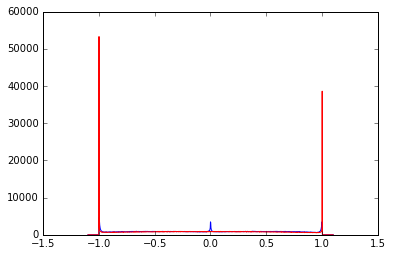

In [29]:
plt.plot(histogram_det_bi[1][1:1001], histogram_det_bi[0])
plt.plot(histogram_sto_bi[1][1:1001], histogram_sto_bi[0], color='r')